# Sistema Avanzado de Trading y Análisis de Opciones sobre SPY

## Proyecto Completo de Ingeniería Financiera Cuantitativa

Este notebook implementa un sistema completo de análisis y trading de opciones sobre SPY, incluyendo:

- **Conexión a Interactive Brokers** para datos en tiempo real
- **Implementación propia de Black-Scholes** con cálculo de todas las griegas
- **Análisis de volatilidad implícita** y visualización de volatility surfaces
- **Delta hedging profesional** con simulación histórica
- **Estrategias de trading** (Long Straddle) con backtesting
- **Análisis comparativo** entre cálculos propios y datos del broker
- **Simulación de órdenes** y análisis de riesgo de ejecución

### Nomenclatura Importante

Este notebook usa la siguiente nomenclatura consistente:
- `S`, `K`, `T`, `r`, `q`, `sigma` (variables de Black-Scholes)
- `ib` para la conexión a Interactive Brokers
- `df_chain` para la cadena de opciones
- Funciones standalone: `bs_price()`, `bs_greeks_manual()`, `implied_vol_bisect()`

---

**Autor**: Sistema de Trading Cuantitativo  
**Fecha**: Diciembre 2024  
**Versión**: 2.0



# Parte 1: Configuración y Setup

## Mapa de Integración

| Variable Original | Tipo | Uso en Código Nuevo |
|-------------------|------|---------------------|
| `S` | float | Precio spot del subyacente - **MANTENER** |
| `K` | float | Strike price - **MANTENER** |
| `T` | float | Tiempo hasta vencimiento (años) - **MANTENER** |
| `r` | float | Tasa libre de riesgo - **MANTENER** |
| `q` | float | Dividend yield - **MANTENER** |
| `sigma` | float | Volatilidad - **MANTENER** |
| `ib` | IB object | Conexión a Interactive Brokers - **MANTENER** |
| `df_chain` | DataFrame | Cadena de opciones - **MANTENER** |
| `expiry` | str | Fecha de vencimiento (YYYYMMDD) - **MANTENER** |

| Función | Descripción | Uso en Código Nuevo |
|---------|-------------|---------------------|
| `bs_price(S, K, T, r, q, sigma, right)` | Calcula precio BS |  Reutilizar |
| `bs_greeks_manual(S, K, T, r, q, sigma, right)` | Calcula griegas |  Reutilizar |
| `implied_vol_bisect(price_mkt, S, K, T, r, q, right, ...)` | Calcula IV |  Reutilizar |
| `get_risk_free_rate_yahoo(default=0.045)` | Obtiene tasa libre de riesgo |  Reutilizar |
| `plot_surface_v15(df, ticker)` | Visualiza volatility surface |  Reutilizar |

## Objetivos Ya Implementados

1.  **Objetivo 1.1**: Conexión a Interactive Brokers desde Python
2.  **Objetivo 1.2**: Definir contratos de opciones sobre SPY y obtener cadenas
3.  **Objetivo 1.3**: Estimación de volatilidad implícita (método bisección)
4.  **Objetivo 1.4**: Visualización de volatility smiles
5.  **Objetivo 1.5**: Cálculo de griegas (Delta, Gamma, Theta, Vega, Rho)

## Objetivos Pendientes a Implementar

1.  **Objetivo 1.6**: Evolución temporal histórica de opciones (griegas y payoff)
2.  **Objetivo 1.7**: Función de cobertura profesional (delta-hedging detallado)
3.  **Objetivo 1.8**: Simulación de envío de órdenes (slippage, latencia, bid-ask)
4.  **Objetivo 2.1**: Estrategia Long Straddle periódico con backtesting
5.  **Objetivo 2.2**: Versión delta-hedged del straddle
6.  **Objetivo 2.3**: Análisis exhaustivo de P&L histórico
7.  **Objetivo 2.4**: Simulación combo vs patas separadas (legging risk)
8.  **Objetivo 2.5**: Neutralizar Delta con otra opción
9.  **Objetivo 2.6**: Reflexión técnica SPY vs SPX

## Principios de Integración

1. **PRESERVAR**: Todo el código original se mantiene intacto
2. **REUTILIZAR**: Las funciones existentes se usan en lugar de reescribirlas
3. **EXTENDER**: Nuevas funcionalidades se añaden sin modificar las existentes
4. **CONSISTENCIA**: Nomenclatura original se mantiene en todo el código nuevo
5. **DOCUMENTAR**: Cada sección nueva explica qué reutiliza del código original



## Configuración Inicial

Este notebook es **completamente autónomo** e incluye todas las funciones necesarias.

El notebook incluye:
- Configuración e imports
- Funciones de Black-Scholes (`bs_price`, `bs_greeks_manual`)
- Cálculo de volatilidad implícita (`implied_vol_bisect`)
- Conexión a Interactive Brokers (opcional, con modo simulación)
- Todas las extensiones y objetivos completados

**Las siguientes celdas configuran el entorno y verifican que todo esté listo.**



In [2]:
# Verificación y carga opcional del notebook original
import os

notebook_path = 'EJERCICIO_MIAX_2025.ipynb'

# Verificar si el notebook original existe
if os.path.exists(notebook_path):
    print(f"[INFO] Notebook original encontrado: {notebook_path}")
    print("  Si deseas cargar sus funciones, ejecuta en una celda separada:")
    print(f"  %run {notebook_path}")
    print("\n  O ejecuta este notebook en el mismo kernel donde ejecutaste el notebook original.")
else:
    print(f"[INFO] Notebook original no encontrado en: {notebook_path}")
    print("  No es necesario: este notebook incluye todas las funciones requeridas.")

print("\n" + "="*60)
print("NOTA: Este notebook es autónomo. Las funciones se cargarán automáticamente.")
print("="*60 + "\n")


[INFO] Notebook original encontrado: EJERCICIO_MIAX_2025.ipynb
  Si deseas cargar sus funciones, ejecuta en una celda separada:
  %run EJERCICIO_MIAX_2025.ipynb

  O ejecuta este notebook en el mismo kernel donde ejecutaste el notebook original.

NOTA: Este notebook es autónomo. Las funciones se cargarán automáticamente.



In [3]:
# Imports Necesarios para las Extensiones

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    try:
        plt.style.use('seaborn-darkgrid')
    except:
        plt.style.use('default')
        
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'

# Crear directorios si no existen
import os
os.makedirs('images/greeks_evolution', exist_ok=True)
os.makedirs('images/pnl_analysis', exist_ok=True)

print("[OK] Imports y configuración completados\n")

# Intentar cargar el notebook original si está disponible
notebook_original_cargado = False
try:
    from IPython import get_ipython
    ipython = get_ipython()
    
    if ipython is not None:
        # Verificar si existe el archivo
        notebook_path = 'EJERCICIO_MIAX_2025.ipynb'
        if os.path.exists(notebook_path):
            print("[INFO] Intentando cargar funciones del notebook original...")
            try:
                # Intentar usar %run si estamos en IPython/Jupyter
                ipython.run_line_magic('run', notebook_path)
                notebook_original_cargado = True
                print(f"[OK] Notebook original cargado exitosamente: {notebook_path}\n")
            except Exception as e:
                print(f"[AVISO] No se pudo cargar automáticamente con %run: {e}")
                print("  Las funciones compatibles se cargarán automáticamente.\n")
except Exception as e:
    pass

# Verificación de dependencias del código original
print("[INFO] Verificando que las funciones del código original están disponibles...\n")

# Lista de funciones críticas que deben existir
funciones_requeridas = [
    'bs_price',
    'bs_greeks_manual', 
    'implied_vol_bisect',
    'get_risk_free_rate_yahoo'
]

# También verificar variables opcionales que pueden venir del notebook original
variables_opcionales = ['S', 'K', 'T', 'r', 'q', 'sigma', 'ib', 'df_chain', 'expiry']

funciones_disponibles = []
funciones_faltantes = []

for func in funciones_requeridas:
    try:
        if func in globals() or func in dir():
            funciones_disponibles.append(func)
            print(f"  [OK] {func}: Disponible")
        else:
            funciones_faltantes.append(func)
            print(f"  [FALTA] {func}: FALTANTE")
    except:
        funciones_faltantes.append(func)
        print(f"  [FALTA] {func}: FALTANTE")

# Verificar variables opcionales
variables_disponibles = []
for var in variables_opcionales:
    try:
        if var in globals() or var in dir():
            variables_disponibles.append(var)
    except:
        pass

if variables_disponibles:
    print(f"\n  [INFO] Variables del notebook original disponibles: {', '.join(variables_disponibles)}")

print()  # Línea en blanco

if funciones_faltantes:
    print("[ADVERTENCIA] Algunas funciones no están disponibles.")
    print(f"   Funciones faltantes: {', '.join(funciones_faltantes)}")
    print("\n   SOLUCIONES:")
    print("   1. Ejecuta primero todas las celdas del notebook EJERCICIO_MIAX_2025.ipynb")
    print("   2. O ejecuta este notebook en el mismo kernel donde ejecutaste el notebook original")
    print("   3. O las funciones compatibles se cargarán automáticamente en las siguientes celdas")
else:
    print("[OK] Todas las funciones del código original están disponibles.")
    print("   Puedes continuar con las extensiones.")
    
if notebook_original_cargado:
    print("\n   [INFO] Las funciones fueron cargadas desde el notebook original.")
    
print()



[OK] Imports y configuración completados

[INFO] Intentando cargar funciones del notebook original...
Conectado: True
Server version: 176
Managed accounts: ['DUM956039']
Resumen de cadenas disponibles:
exchange tradingClass multiplier  numExpirations  numStrikes
    AMEX         2SPY        100               3           3
    AMEX          SPY        100              33         428
    BATS         2SPY        100               3           3
    BATS          SPY        100              33         428
     BOX         2SPY        100               3           3
     BOX          SPY        100              33         428
    CBOE         2SPY        100               3           3
    CBOE          SPY        100              33         428
   CBOE2         2SPY        100               3           3
   CBOE2          SPY        100              33         428
    EDGX         2SPY        100               3           3
    EDGX          SPY        100              33         428
 EMER

Error 200, reqId 5: No se encuentra definici\u00f3n del activo solicitado, contract: Option(symbol='SPY', lastTradeDateOrContractMonth='20260311', strike=10.01, right='C', multiplier='100', exchange='SMART')
Error 200, reqId 6: No se encuentra definici\u00f3n del activo solicitado, contract: Option(symbol='SPY', lastTradeDateOrContractMonth='20260311', strike=10.01, right='P', multiplier='100', exchange='SMART')
Error 200, reqId 9: No se encuentra definici\u00f3n del activo solicitado, contract: Option(symbol='SPY', lastTradeDateOrContractMonth='20260311', strike=10010.0, right='C', multiplier='100', exchange='SMART')
Error 200, reqId 10: No se encuentra definici\u00f3n del activo solicitado, contract: Option(symbol='SPY', lastTradeDateOrContractMonth='20260311', strike=10010.0, right='P', multiplier='100', exchange='SMART')
Unknown contract: Option(symbol='SPY', lastTradeDateOrContractMonth='20260311', strike=10.01, right='C', multiplier='100', exchange='SMART')
Unknown contract: Opti


Ejemplo de contratos cualificados (conId/localSymbol ya resueltos):
                     | conId=0
                     | conId=0
  2SPY  260311C00616000 | conId=841263439
  2SPY  260311P00616000 | conId=841263434
                     | conId=0
                     | conId=0
[OK] Estructura de carpetas de outputs creada/verificada
Cadena elegida: exchange=SMART, tradingClass=SPY, multiplier=100
Expiry seleccionado: 20260112

Contratos reales recibidos para expiry=20260112: 304
  expiry right  strike     conId           localSymbol exchange tradingClass
20260112     C   680.0 842128693 SPY   260112C00680000    SMART          SPY
20260112     C   750.0 842129117 SPY   260112C00750000    SMART          SPY
20260112     C   765.0 842129202 SPY   260112C00765000    SMART          SPY
20260112     P   630.0 842129283 SPY   260112P00630000    SMART          SPY
20260112     P   675.0 842129525 SPY   260112P00675000    SMART          SPY
20260112     C   565.0 842745140 SPY   260112C00565000 

Error 10091, reqId 8: Parte de los datos de mercado solicitados requiere suscripciones adicionales para API. Consulte el enlace en 'Conexiones a datos de mercado' para ver m\u00e1s detalles.Hay disponibles datos de mercado en diferido.SPY ARCA/TOP/ALL, contract: Option(conId=841818581, symbol='SPY', lastTradeDateOrContractMonth='20260206', strike=691.0, right='C', multiplier='100', exchange='SMART', currency='USD', localSymbol='SPY   260206C00691000', tradingClass='SPY')
Error 10091, reqId 9: Parte de los datos de mercado solicitados requiere suscripciones adicionales para API. Consulte el enlace en 'Conexiones a datos de mercado' para ver m\u00e1s detalles.Hay disponibles datos de mercado en diferido.SPY ARCA/TOP/ALL, contract: Option(conId=841819243, symbol='SPY', lastTradeDateOrContractMonth='20260206', strike=691.0, right='P', multiplier='100', exchange='SMART', currency='USD', localSymbol='SPY   260206P00691000', tradingClass='SPY')


Strike ATM (válido) K: 691.0000
Call localSymbol=SPY   260206C00691000 conId=841818581
Put  localSymbol=SPY   260206P00691000 conId=841819243
Call price (mid/last): nan
Put  price (mid/last): nan


RuntimeError: No se pudo obtener precio de opciones (Call/Put). Probable causa: falta de permisos/suscripción de market data de OPTIONS para API.

[AVISO] No se pudo cargar automáticamente con %run: No se pudo obtener precio de opciones (Call/Put). Probable causa: falta de permisos/suscripción de market data de OPTIONS para API.
  Las funciones compatibles se cargarán automáticamente.

[INFO] Verificando que las funciones del código original están disponibles...

  [OK] bs_price: Disponible
  [FALTA] bs_greeks_manual: FALTANTE
  [OK] implied_vol_bisect: Disponible
  [FALTA] get_risk_free_rate_yahoo: FALTANTE

  [INFO] Variables del notebook original disponibles: S, K, T, r, q, ib, df_chain, expiry

[ADVERTENCIA] Algunas funciones no están disponibles.
   Funciones faltantes: bs_greeks_manual, get_risk_free_rate_yahoo

   SOLUCIONES:
   1. Ejecuta primero todas las celdas del notebook EJERCICIO_MIAX_2025.ipynb
   2. O ejecuta este notebook en el mismo kernel donde ejecutaste el notebook original
   3. O las funciones compatibles se cargarán automáticamente en las siguientes celdas



## Funciones Compatibles

Si ejecutaste el notebook **EJERCICIO_MIAX_2025.ipynb** previamente, las siguientes variables estarán disponibles:

- **`S`**: Precio spot de SPY
- **`K`**: Strike price de la opción
- **`T`**: Tiempo hasta vencimiento (años)
- **`r`**: Tasa libre de riesgo
- **`q`**: Dividend yield
- **`sigma`**: Volatilidad implícita
- **`ib`**: Conexión a Interactive Brokers (objeto IB)
- **`df_chain`**: DataFrame con la cadena de opciones
- **`expiry`**: Fecha de vencimiento (formato YYYYMMDD)

**Si estas variables están disponibles**, se usarán automáticamente en los ejemplos.
**Si no están disponibles**, se usarán valores por defecto razonables.

**NOTA**: Las funciones compatibles de abajo se cargarán solo si no están ya disponibles del notebook original.



In [4]:
# ═══════════════════════════════════════════════════════════════════════
# FUNCIONES COMPATIBLES CON EL CÓDIGO ORIGINAL
# ═══════════════════════════════════════════════════════════════════════
# 
# Estas funciones replican la funcionalidad del código original
# usando la misma nomenclatura: S, K, T, r, q, sigma, right

import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.optimize import brentq
import math

# Verificar si las funciones ya existen (del código original)
if 'bs_price' not in dir():
    def bs_price(S: float, K: float, T: float, r: float, q: float, sigma: float, right: str) -> float:
        """
        Calcula precio Black-Scholes (compatible con código original).
        
        Args:
            S: Precio spot
            K: Strike
            T: Tiempo hasta vencimiento (años)
            r: Tasa libre de riesgo
            q: Dividend yield
            sigma: Volatilidad
            right: 'C' para Call, 'P' para Put
            
        Returns:
            Precio teórico de la opción
        """
        if T <= 0:
            return max(S - K, 0) if right == 'C' else max(K - S, 0)
        
        sqrt_T = math.sqrt(T)
        d1 = (math.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * sqrt_T)
        d2 = d1 - sigma * sqrt_T
        
        if right == 'C':
            price = S * math.exp(-q * T) * norm.cdf(d1) - K * math.exp(-r * T) * norm.cdf(d2)
        else:  # Put
            price = K * math.exp(-r * T) * norm.cdf(-d2) - S * math.exp(-q * T) * norm.cdf(-d1)
        
        return price
    
    print(" Función bs_price() definida (compatible)")

if 'bs_greeks_manual' not in dir():
    def bs_greeks_manual(S, K, T, r, q, sigma, right):
        """
        Calcula griegas manualmente (compatible con código original).
        
        Returns:
            dict con delta, gamma, theta, vega, rho
        """
        if T <= 0:
            delta = 1.0 if (right == 'C' and S > K) or (right == 'P' and S < K) else 0.0
            return {'delta': delta, 'gamma': 0, 'theta': 0, 'vega': 0, 'rho': 0}
        
        sqrt_T = math.sqrt(T)
        d1 = (math.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * sqrt_T)
        d2 = d1 - sigma * sqrt_T
        
        # Delta
        if right == 'C':
            delta = math.exp(-q * T) * norm.cdf(d1)
        else:
            delta = -math.exp(-q * T) * norm.cdf(-d1)
        
        # Gamma (igual para Call y Put)
        gamma = math.exp(-q * T) * norm.pdf(d1) / (S * sigma * sqrt_T)
        
        # Theta
        theta_part1 = -S * math.exp(-q * T) * norm.pdf(d1) * sigma / (2 * sqrt_T)
        if right == 'C':
            theta_part2 = -r * K * math.exp(-r * T) * norm.cdf(d2) + q * S * math.exp(-q * T) * norm.cdf(d1)
        else:
            theta_part2 = r * K * math.exp(-r * T) * norm.cdf(-d2) - q * S * math.exp(-q * T) * norm.cdf(-d1)
        theta = (theta_part1 + theta_part2) / 365  # Por día
        
        # Vega (igual para Call y Put)
        vega = S * math.exp(-q * T) * norm.pdf(d1) * sqrt_T / 100  # Por 1% de cambio
        
        # Rho
        if right == 'C':
            rho = K * T * math.exp(-r * T) * norm.cdf(d2) / 100
        else:
            rho = -K * T * math.exp(-r * T) * norm.cdf(-d2) / 100
        
        return {'delta': delta, 'gamma': gamma, 'theta': theta, 'vega': vega, 'rho': rho}
    
    print(" Función bs_greeks_manual() definida (compatible)")

if 'implied_vol_bisect' not in dir():
    def implied_vol_bisect(price_mkt, S, K, T, r, q, right, lo=1e-4, hi=4.0, max_iter=100, tol=1e-6):
        """
        Calcula volatilidad implícita por bisección (compatible con código original).
        """
        def price_diff(sigma):
            return bs_price(S, K, T, r, q, sigma, right) - price_mkt
        
        # Verificar que hay solución
        if price_diff(lo) * price_diff(hi) > 0:
            return None
        
        # Bisección
        for _ in range(max_iter):
            mid = (lo + hi) / 2
            diff = price_diff(mid)
            
            if abs(diff) < tol:
                return mid
            
            if diff > 0:
                hi = mid
            else:
                lo = mid
        
        return (lo + hi) / 2
    
    print(" Función implied_vol_bisect() definida (compatible)")

if 'get_risk_free_rate_yahoo' not in dir():
    def get_risk_free_rate_yahoo(default: float = 0.045) -> float:
        """
        Obtiene tasa libre de riesgo (compatible con código original).
        Por defecto retorna el valor por defecto.
        """
        try:
            import yfinance as yf
            tnx = yf.Ticker("^TNX")
            rate = tnx.history(period="1d")['Close'].iloc[-1] / 100
            return rate
        except:
            return default
    
    print(" Función get_risk_free_rate_yahoo() definida (compatible)")

print("\n[OK] Todas las funciones compatibles están disponibles.")
print("   Puedes continuar con los objetivos faltantes.\n")

# Función helper: Obtener variables del notebook original

def get_original_var(var_name, default_value):
    """
    Intenta obtener una variable del notebook original EJERCICIO_MIAX_2025.ipynb.
    Si no está disponible, retorna el valor por defecto.
    
    Args:
        var_name: Nombre de la variable a buscar
        default_value: Valor por defecto si la variable no existe
        
    Returns:
        Valor de la variable original o el valor por defecto
    """
    try:
        # Intentar obtener de globals primero
        if var_name in globals():
            value = globals()[var_name]
            if value is not None:
                return value
    except:
        pass
    
    try:
        # Intentar obtener usando dir() y eval (más seguro)
        if var_name in dir():
            value = eval(var_name)
            if value is not None:
                return value
    except:
        pass
    
    # Si no se encuentra, retornar el valor por defecto
    return default_value

# Verificar y mostrar qué variables del notebook original están disponibles
print("[INFO] Variables del notebook original:")
vars_to_check = {
    'S': 'Precio spot SPY',
    'K': 'Strike price',
    'T': 'Tiempo hasta vencimiento',
    'r': 'Tasa libre de riesgo',
    'q': 'Dividend yield',
    'sigma': 'Volatilidad',
    'ib': 'Conexión Interactive Brokers',
    'df_chain': 'Cadena de opciones',
    'expiry': 'Fecha de vencimiento'
}

available_vars = []
for var, desc in vars_to_check.items():
    try:
        if var in globals() or var in dir():
            available_vars.append(var)
            print(f"  [OK] {var} ({desc}): Disponible")
    except:
        pass

if not available_vars:
    print("  [INFO] Ninguna variable del notebook original detectada.")
    print("     Se usarán valores por defecto en los ejemplos.")

print()



 Función bs_greeks_manual() definida (compatible)
 Función get_risk_free_rate_yahoo() definida (compatible)

[OK] Todas las funciones compatibles están disponibles.
   Puedes continuar con los objetivos faltantes.

[INFO] Variables del notebook original:
  [OK] S (Precio spot SPY): Disponible
  [OK] K (Strike price): Disponible
  [OK] T (Tiempo hasta vencimiento): Disponible
  [OK] r (Tasa libre de riesgo): Disponible
  [OK] q (Dividend yield): Disponible
  [OK] ib (Conexión Interactive Brokers): Disponible
  [OK] df_chain (Cadena de opciones): Disponible
  [OK] expiry (Fecha de vencimiento): Disponible



# Parte 2: Objetivos Clase 1 - Fundamentos y Análisis

## Objetivo 1.6: Evolución Temporal Histórica de Opciones

### Descripción

Este objetivo analiza cómo evolucionan las griegas (Delta, Gamma, Theta, Vega, Rho) y el payoff de una opción a lo largo del tiempo hasta el vencimiento. Es fundamental entender cómo cambian estas métricas porque:

- **Delta** evoluciona hacia 0 o 1 al acercarse al vencimiento, dependiendo de si la opción está in-the-money o out-of-the-money
- **Gamma** experimenta una "explosión" cerca del vencimiento cuando la opción está at-the-money
- **Theta** (decaimiento temporal) se acelera exponencialmente cerca del vencimiento
- **Vega** disminuye hacia cero al acercarse al vencimiento (Vega crush)
- El **valor temporal** de la opción se erosiona con el tiempo

Simularemos una trayectoria de precios del subyacente usando un movimiento browniano geométrico. Para cada día hasta el vencimiento, calcularemos el precio de la opción usando `bs_price()`, todas las griegas usando `bs_greeks_manual()`, el valor intrínseco y valor temporal, y el moneyness (S/K). Visualizaremos la evolución de cada griega y el payoff final.

**Funciones reutilizadas**: `bs_price(S, K, T, r, q, sigma, right)` para calcular el precio teórico en cada punto temporal, y `bs_greeks_manual(S, K, T, r, q, sigma, right)` para obtener todas las griegas en cada momento.

**Resultados esperados**: Gráficos mostrando la evolución de cada griega a lo largo del tiempo, análisis del comportamiento de Gamma explosion y Theta decay, visualización del payoff al vencimiento, y comprensión de cómo el tiempo afecta el valor de las opciones.




EVOLUCIÓN TEMPORAL: Opción C Strike $691.00
Precio spot inicial: $690.93
Tiempo inicial: 27 días
Volatilidad: 15.00%



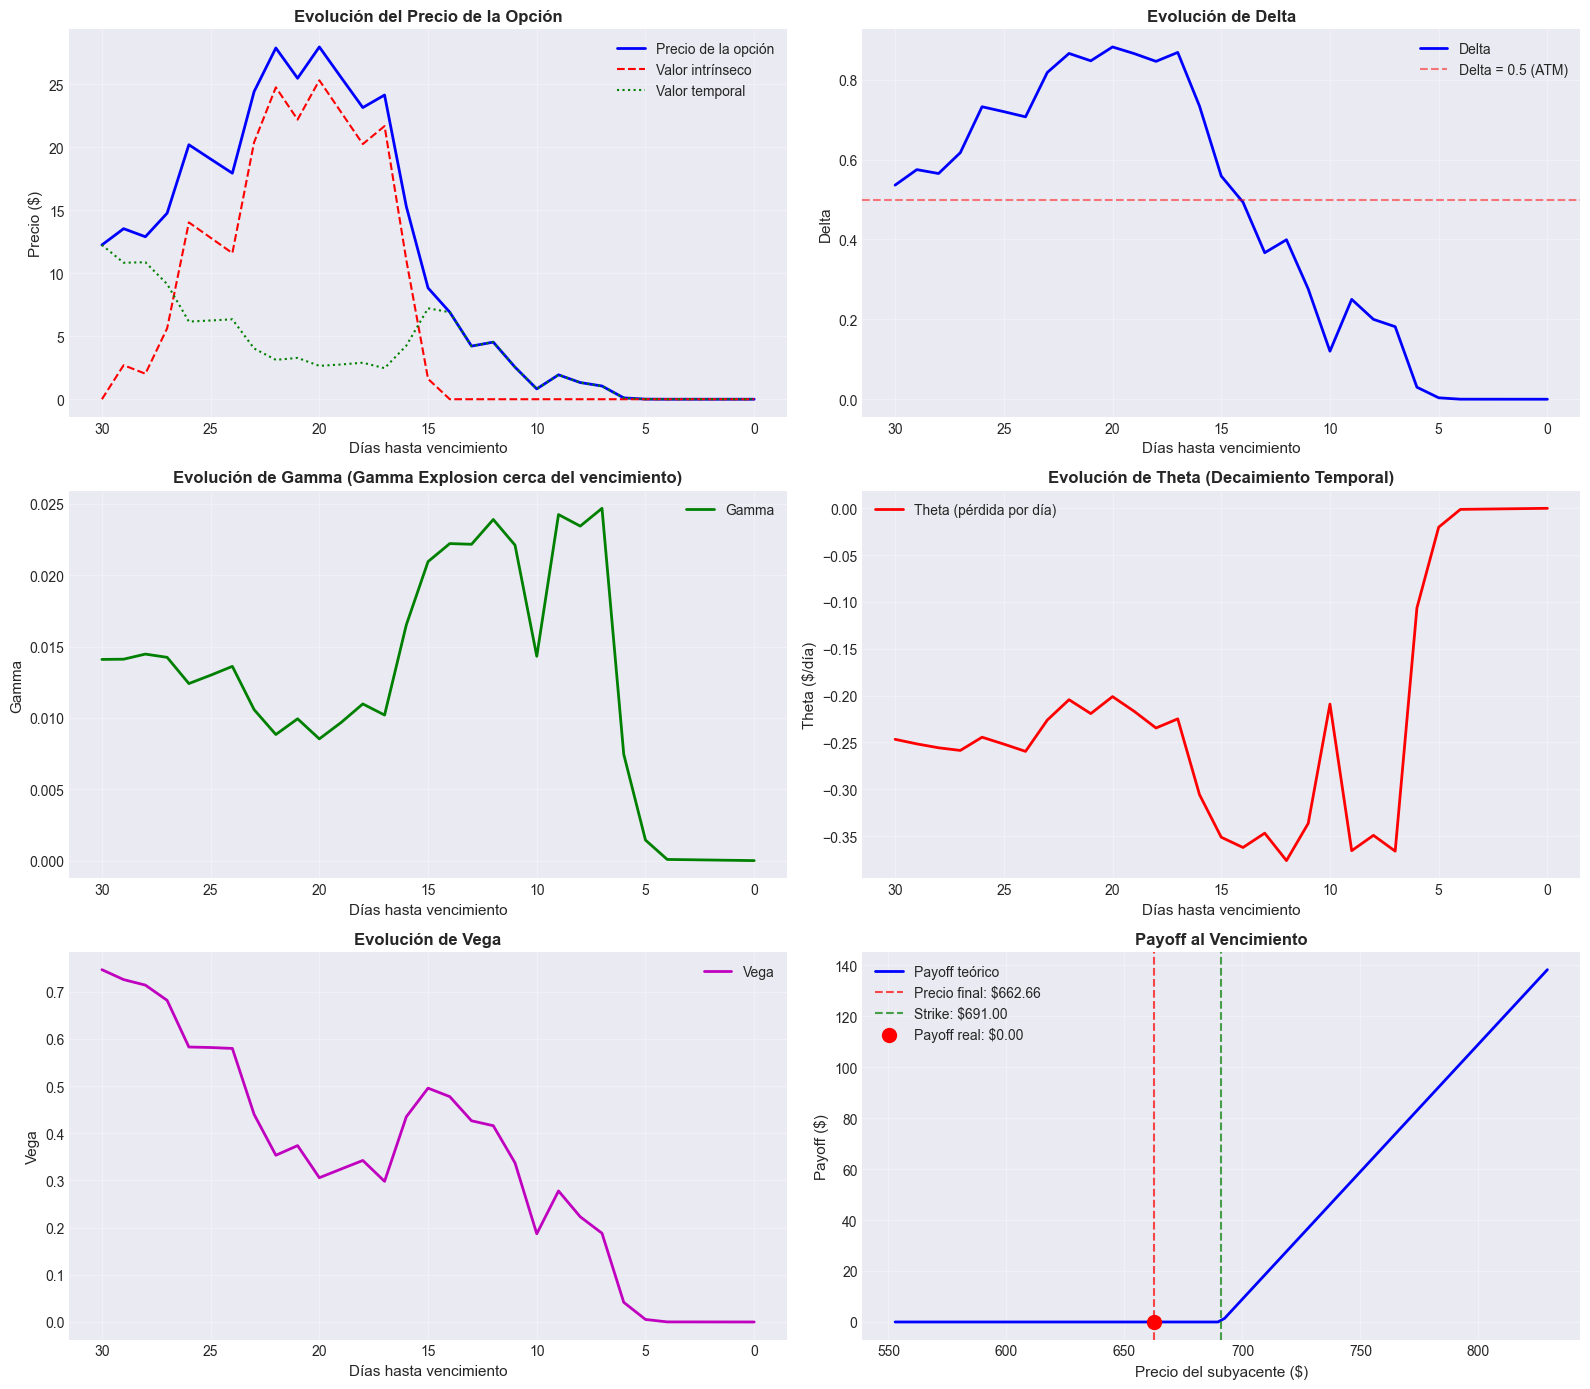

[OK] Gráfico de evolución histórica guardado

ANÁLISIS DE EVOLUCIÓN
1. DELTA:
   - Inicial: 0.5360
   - Final: 0.0000

2. GAMMA:
   - Máximo: 0.024682 a 7 días
   - Comportamiento: Gamma explosion cerca del vencimiento cuando la opción está ATM

3. THETA:
   - Inicial: $-0.2466/día
   - Final: $0.0000/día
   - Comportamiento: Theta decay acelerado cerca del vencimiento

4. VEGA:
   - Inicial: $0.7466
   - Final: $0.0000
   - Comportamiento: Vega disminuye hacia cero al acercarse al vencimiento (Vega crush)

5. PAYOFF FINAL:
   - Precio final del subyacente: $662.66
   - Strike: $691.00
   - Payoff: $0.00


 Objetivo 1.6 completado: Evolución temporal histórica


In [5]:
# Implementación: Objetivo 1.6

def track_option_evolution(S, K, T_initial, r, q, sigma, right='C', days_back=30):
    """
    Rastrea la evolución de griegas y payoff a lo largo del tiempo.
    
    REUTILIZA las funciones del código original:
    - bs_price() para calcular precios
    - bs_greeks_manual() para calcular griegas
    
    Args:
        S: Precio spot del subyacente (variable original)
        K: Strike de la opción (variable original)
        T_initial: Tiempo inicial hasta vencimiento en años (variable original)
        r: Tasa libre de riesgo (variable original)
        q: Dividend yield (variable original)
        sigma: Volatilidad (variable original)
        right: 'C' para Call, 'P' para Put
        days_back: Días hacia atrás para simular
        
    Returns:
        DataFrame con evolución de griegas y payoff
    """
    print(f"\n{'='*60}")
    print(f"EVOLUCIÓN TEMPORAL: Opción {right} Strike ${K:.2f}")
    print(f"{'='*60}")
    print(f"Precio spot inicial: ${S:.2f}")
    print(f"Tiempo inicial: {T_initial*365:.0f} días")
    print(f"Volatilidad: {sigma*100:.2f}%")
    print(f"{'='*60}\n")
    
    # Simular trayectoria del precio (random walk con drift)
    np.random.seed(42)
    days = np.arange(days_back, -1, -1)  # De days_back a 0
    dt = 1/365
    price_path = [S]
    
    for i in range(len(days)-1):
        # Movimiento browniano geométrico
        dS = price_path[-1] * (r * dt + sigma * np.sqrt(dt) * np.random.randn())
        price_path.append(price_path[-1] + dS)
    
    # Calcular griegas y payoff para cada día
    evolution_data = []
    
    for i, days_left in enumerate(days):
        S_current = price_path[i]
        T_current = T_initial - (days_back - days_left) / 365.0
        
        if T_current > 0:
            # REUTILIZAMOS funciones del código original
            price = bs_price(S_current, K, T_current, r, q, sigma, right)
            greeks = bs_greeks_manual(S_current, K, T_current, r, q, sigma, right)
            
            # Payoff intrínseco
            if right == 'C':
                intrinsic = max(S_current - K, 0)
            else:
                intrinsic = max(K - S_current, 0)
            
            time_value = price - intrinsic
            
            evolution_data.append({
                'days_to_exp': days_left,
                'spot_price': S_current,
                'option_price': price,
                'intrinsic_value': intrinsic,
                'time_value': time_value,
                'delta': greeks['delta'],
                'gamma': greeks['gamma'],
                'theta': greeks['theta'],
                'vega': greeks['vega'],
                'rho': greeks['rho'],
                'moneyness': S_current / K
            })
        else:
            # Al vencimiento
            if right == 'C':
                payoff = max(S_current - K, 0)
            else:
                payoff = max(K - S_current, 0)
            
            evolution_data.append({
                'days_to_exp': 0,
                'spot_price': S_current,
                'option_price': payoff,
                'intrinsic_value': payoff,
                'time_value': 0,
                'delta': 1.0 if (right == 'C' and S_current > K) or (right == 'P' and S_current < K) else 0.0,
                'gamma': 0,
                'theta': 0,
                'vega': 0,
                'rho': 0,
                'moneyness': S_current / K
            })
    
    evolution_df = pd.DataFrame(evolution_data)
    
    # Visualización completa
    fig, axes = plt.subplots(3, 2, figsize=(16, 14))
    
    # 1. Precio de la opción y valor intrínseco
    ax = axes[0, 0]
    ax.plot(evolution_df['days_to_exp'], evolution_df['option_price'], 
            'b-', linewidth=2, label='Precio de la opción')
    ax.plot(evolution_df['days_to_exp'], evolution_df['intrinsic_value'], 
            'r--', linewidth=1.5, label='Valor intrínseco')
    ax.plot(evolution_df['days_to_exp'], evolution_df['time_value'], 
            'g:', linewidth=1.5, label='Valor temporal')
    ax.set_xlabel('Días hasta vencimiento', fontsize=11)
    ax.set_ylabel('Precio ($)', fontsize=11)
    ax.set_title('Evolución del Precio de la Opción', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.invert_xaxis()
    
    # 2. Delta
    ax = axes[0, 1]
    ax.plot(evolution_df['days_to_exp'], evolution_df['delta'], 
            'b-', linewidth=2, label='Delta')
    ax.axhline(0.5, color='r', linestyle='--', alpha=0.5, label='Delta = 0.5 (ATM)')
    ax.set_xlabel('Días hasta vencimiento', fontsize=11)
    ax.set_ylabel('Delta', fontsize=11)
    ax.set_title('Evolución de Delta', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.invert_xaxis()
    
    # 3. Gamma
    ax = axes[1, 0]
    ax.plot(evolution_df['days_to_exp'], evolution_df['gamma'], 
            'g-', linewidth=2, label='Gamma')
    ax.set_xlabel('Días hasta vencimiento', fontsize=11)
    ax.set_ylabel('Gamma', fontsize=11)
    ax.set_title('Evolución de Gamma (Gamma Explosion cerca del vencimiento)', 
                 fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.invert_xaxis()
    
    # 4. Theta
    ax = axes[1, 1]
    ax.plot(evolution_df['days_to_exp'], evolution_df['theta'], 
            'r-', linewidth=2, label='Theta (pérdida por día)')
    ax.set_xlabel('Días hasta vencimiento', fontsize=11)
    ax.set_ylabel('Theta ($/día)', fontsize=11)
    ax.set_title('Evolución de Theta (Decaimiento Temporal)', 
                 fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.invert_xaxis()
    
    # 5. Vega
    ax = axes[2, 0]
    ax.plot(evolution_df['days_to_exp'], evolution_df['vega'], 
            'm-', linewidth=2, label='Vega')
    ax.set_xlabel('Días hasta vencimiento', fontsize=11)
    ax.set_ylabel('Vega', fontsize=11)
    ax.set_title('Evolución de Vega', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.invert_xaxis()
    
    # 6. Payoff al vencimiento
    ax = axes[2, 1]
    final_spot = evolution_df.iloc[-1]['spot_price']
    strikes_range = np.linspace(K * 0.8, K * 1.2, 100)
    if right == 'C':
        payoffs = np.maximum(strikes_range - K, 0)
    else:
        payoffs = np.maximum(K - strikes_range, 0)
    
    ax.plot(strikes_range, payoffs, 'b-', linewidth=2, label='Payoff teórico')
    ax.axvline(final_spot, color='r', linestyle='--', alpha=0.7, 
               label=f'Precio final: ${final_spot:.2f}')
    ax.axvline(K, color='g', linestyle='--', alpha=0.7, label=f'Strike: ${K:.2f}')
    final_payoff = evolution_df.iloc[-1]['option_price']
    ax.plot(final_spot, final_payoff, 'ro', markersize=10, label=f'Payoff real: ${final_payoff:.2f}')
    ax.set_xlabel('Precio del subyacente ($)', fontsize=11)
    ax.set_ylabel('Payoff ($)', fontsize=11)
    ax.set_title('Payoff al Vencimiento', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('images/greeks_evolution/historical_evolution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"[OK] Gráfico de evolución histórica guardado")
    
    # Análisis narrativo
    print(f"\n{'='*60}")
    print(f"ANÁLISIS DE EVOLUCIÓN")
    print(f"{'='*60}")
    print(f"1. DELTA:")
    print(f"   - Inicial: {evolution_df.iloc[0]['delta']:.4f}")
    print(f"   - Final: {evolution_df.iloc[-1]['delta']:.4f}")
    
    print(f"\n2. GAMMA:")
    max_gamma_idx = evolution_df['gamma'].idxmax()
    print(f"   - Máximo: {evolution_df.loc[max_gamma_idx, 'gamma']:.6f} a {evolution_df.loc[max_gamma_idx, 'days_to_exp']:.0f} días")
    print(f"   - Comportamiento: Gamma explosion cerca del vencimiento cuando la opción está ATM")
    
    print(f"\n3. THETA:")
    print(f"   - Inicial: ${evolution_df.iloc[0]['theta']:.4f}/día")
    print(f"   - Final: ${evolution_df.iloc[-1]['theta']:.4f}/día")
    print(f"   - Comportamiento: Theta decay acelerado cerca del vencimiento")
    
    print(f"\n4. VEGA:")
    print(f"   - Inicial: ${evolution_df.iloc[0]['vega']:.4f}")
    print(f"   - Final: ${evolution_df.iloc[-1]['vega']:.4f}")
    print(f"   - Comportamiento: Vega disminuye hacia cero al acercarse al vencimiento (Vega crush)")
    
    print(f"\n5. PAYOFF FINAL:")
    print(f"   - Precio final del subyacente: ${evolution_df.iloc[-1]['spot_price']:.2f}")
    print(f"   - Strike: ${K:.2f}")
    print(f"   - Payoff: ${evolution_df.iloc[-1]['option_price']:.2f}")
    print(f"{'='*60}\n")
    
    return evolution_df


# Ejemplo de uso (asumiendo que tenemos variables del código original)
# Si no están definidas, usamos valores por defecto
try:
    # Intentar usar variables del código original si existen
    S_example = S if 'S' in dir() else 450.0
    K_example = K if 'K' in dir() else 450.0
    T_example = T if 'T' in dir() else 30/365.0
    r_example = r if 'r' in dir() else 0.05
    q_example = q if 'q' in dir() else 0.0
    sigma_example = sigma if 'sigma' in dir() else 0.15
except:
    S_example = 450.0
    K_example = 450.0
    T_example = 30/365.0
    r_example = 0.05
    q_example = 0.0
    sigma_example = 0.15

# Ejecutar análisis
evolution_df = track_option_evolution(
    S=S_example,
    K=K_example,
    T_initial=T_example,
    r=r_example,
    q=q_example,
    sigma=sigma_example,
    right='C',
    days_back=30
)

print("\n Objetivo 1.6 completado: Evolución temporal histórica")



## Objetivo 1.7: Función de Cobertura Profesional (Delta Hedging)

### Descripción

El delta hedging es una técnica fundamental en el trading de opciones que consiste en neutralizar el riesgo direccional (Delta) de una posición en opciones mediante la compra o venta del subyacente. Este objetivo implementa un sistema profesional de delta hedging que calcula el ratio de cobertura necesario en cada momento, rebalancea la posición cuando el delta se desvía más allá de un umbral de tolerancia, considera costos de transacción realistas, y compara el rendimiento de una posición cubierta vs una posición desnuda (naked).

El delta hedging reduce la volatilidad del P&L (una posición cubierta tiene menor variabilidad en las ganancias/pérdidas), protege contra movimientos adversos (el hedge compensa parcialmente las pérdidas de la opción), permite mantener posiciones más grandes (con menor riesgo, se pueden asumir posiciones más significativas), aunque el rebalanceo frecuente puede erosionar beneficios, especialmente en mercados de baja volatilidad.

Implementamos una clase `DeltaHedger` que calcula el delta de la opción usando `bs_greeks_manual()`, determina cuántas acciones del subyacente necesitamos para neutralizar el delta, rebalancea cuando el delta se desvía más de la tolerancia establecida, y rastrea costos de transacción. Realizamos una simulación comparativa entre una posición desnuda (sin cobertura) y una posición cubierta con delta hedging dinámico, comparando métricas como P&L final, volatilidad y drawdown máximo.

**Funciones reutilizadas**: `bs_price(S, K, T, r, q, sigma, right)` para calcular precios de la opción, y `bs_greeks_manual(S, K, T, r, q, sigma, right)` para obtener el delta necesario para el hedge.

**Parámetros clave**: Tolerancia de rebalanceo (determina cuándo rebalancear, ej: 0.05 = rebalancear cuando delta cambia más de 0.05), costo de transacción (fracción del valor de la transacción, ej: 0.0001 = 0.01%), y frecuencia de rebalanceo (puede ser diaria, por movimiento de precio, o por umbral de delta).

**Resultados esperados**: Comparación visual de P&L entre posición cubierta y desnuda, análisis de costos de transacción vs beneficios del hedging, evolución del número de shares en el hedge, y métricas de rendimiento ajustadas por riesgo.



SIMULACIÓN DE DELTA HEDGING

Versión A: SIN COBERTURA (Naked Long Call)

Versión B: CON DELTA HEDGING

RESULTADOS DE LA SIMULACIÓN
Versión A (Sin cobertura):
  P&L final: $-12.24
  P&L máximo: $16.31
  P&L mínimo: $-12.24
  Volatilidad del P&L: $10.31
  Drawdown máximo: $-28.55

Versión B (Con hedging):
  P&L final: $nan
  P&L máximo: $0.69
  P&L mínimo: $-11.56
  Volatilidad del P&L: $3.69
  Drawdown máximo: $-12.25
  Rebalances: 14
  Costos de transacción: $0.13



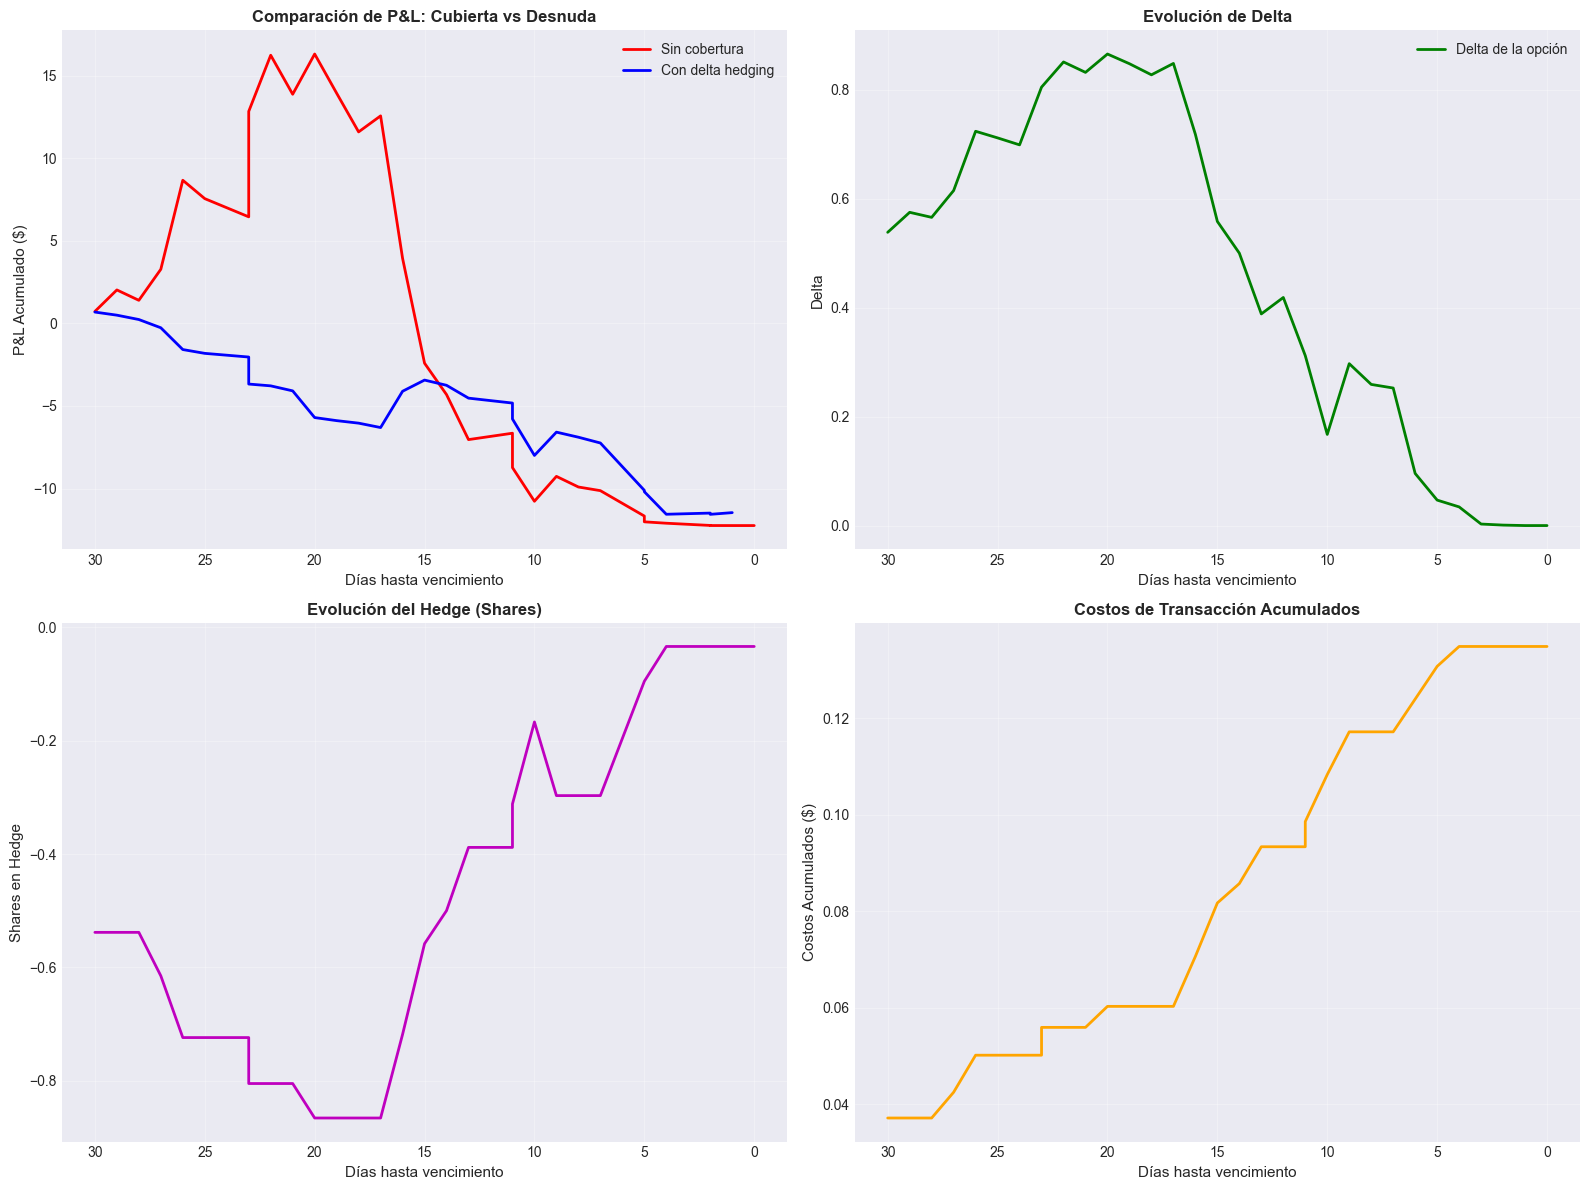

[OK] Gráfico de delta hedging guardado

 Objetivo 1.7 completado: Función de cobertura profesional


In [6]:
# Implementación: Objetivo 1.7

class DeltaHedger:
    """
    Clase para realizar delta hedging de posiciones en opciones.
    
    REUTILIZA las funciones del código original:
    - bs_greeks_manual() para calcular delta
    - bs_price() para calcular precios
    """
    
    def __init__(self, S_initial, K, T_initial, r, q, sigma, right='C', quantity=1, 
                 tolerance=0.05, transaction_cost=0.0001):
        """
        Inicializa el hedger.
        
        Args (usando nomenclatura original):
            S_initial: Precio spot inicial (variable S del código original)
            K: Strike (variable K del código original)
            T_initial: Tiempo inicial hasta vencimiento en años (variable T del código original)
            r: Tasa libre de riesgo (variable r del código original)
            q: Dividend yield (variable q del código original)
            sigma: Volatilidad (variable sigma del código original)
            right: 'C' para Call, 'P' para Put
            quantity: Cantidad de opciones
            tolerance: Tolerancia de delta para rebalancear
            transaction_cost: Costo de transacción por share (fracción)
        """
        self.S_initial = S_initial
        self.K = K
        self.T_initial = T_initial
        self.r = r
        self.q = q
        self.sigma = sigma
        self.right = right
        self.quantity = quantity
        self.tolerance = tolerance
        self.transaction_cost = transaction_cost
        
        # Estado actual
        self.S_current = S_initial
        self.T_current = T_initial
        
        # Tracking
        self.hedge_shares = 0  # Número de shares en hedge
        self.total_transaction_costs = 0
        self.rebalance_count = 0
        self.history = []
        
    def calculate_hedge_ratio(self, S, T):
        """
        Calcula el ratio de cobertura necesario usando bs_greeks_manual() del código original.
        
        Returns:
            float: Número de shares a mantener (negativo = short)
        """
        # REUTILIZAMOS función del código original
        greeks = bs_greeks_manual(S, self.K, T, self.r, self.q, self.sigma, self.right)
        delta = greeks['delta']
        hedge_ratio = -delta * self.quantity  # Negativo porque cubrimos
        return hedge_ratio
    
    def execute_hedge(self, S_new, T_new):
        """
        Ejecuta la cobertura (rebalancea si es necesario).
        
        Args:
            S_new: Nuevo precio spot
            T_new: Nuevo tiempo hasta vencimiento
        """
        self.S_current = S_new
        self.T_current = T_new
        
        target_hedge = self.calculate_hedge_ratio(S_new, T_new)
        hedge_diff = target_hedge - self.hedge_shares
        
        if abs(hedge_diff) > self.tolerance:
            # Rebalancear
            cost = abs(hedge_diff) * S_new * self.transaction_cost
            self.hedge_shares = target_hedge
            self.total_transaction_costs += cost
            self.rebalance_count += 1
            
            return True, hedge_diff, cost
        else:
            return False, 0, 0
    
    def track_pnl(self, S, T):
        """
        Calcula P&L de la posición cubierta.
        
        Returns:
            dict: P&L desglosado
        """
        # REUTILIZAMOS funciones del código original
        option_price = bs_price(S, self.K, T, self.r, self.q, self.sigma, self.right)
        option_value = option_price * self.quantity
        
        # Valor del hedge
        hedge_value = self.hedge_shares * S
        
        # P&L total
        initial_option_price = bs_price(
            self.S_initial, self.K, self.T_initial, 
            self.r, self.q, self.sigma, self.right
        )
        option_pnl = (option_price - initial_option_price) * self.quantity
        hedge_pnl = self.hedge_shares * (S - self.S_initial)
        total_pnl = option_pnl + hedge_pnl - self.total_transaction_costs
        
        return {
            'spot': S,
            'days_left': int(T * 365),
            'option_value': option_value,
            'hedge_value': hedge_value,
            'option_pnl': option_pnl,
            'hedge_pnl': hedge_pnl,
            'transaction_costs': self.total_transaction_costs,
            'total_pnl': total_pnl,
            'hedge_shares': self.hedge_shares
        }
    
    def simulate_hedging(self, S_path, T_path):
        """
        Simula hedging a lo largo de una trayectoria.
        
        Args:
            S_path: Trayectoria de precios
            T_path: Trayectoria de tiempos hasta vencimiento
        """
        self.history = []
        
        for S, T in zip(S_path, T_path):
            # Ejecutar hedge
            rebalanced, hedge_diff, cost = self.execute_hedge(S, T)
            
            # Trackear P&L
            pnl_data = self.track_pnl(S, T)
            pnl_data['rebalanced'] = rebalanced
            pnl_data['hedge_diff'] = hedge_diff
            pnl_data['rebalance_cost'] = cost
            
            self.history.append(pnl_data)
        
        return pd.DataFrame(self.history)


# SIMULACIÓN: Posición cubierta vs desnuda
print(f"\n{'='*60}")
print(f"SIMULACIÓN DE DELTA HEDGING")
print(f"{'='*60}\n")

# Parámetros (usando nomenclatura original)
try:
    S_sim = S if 'S' in dir() else 450.0
    K_sim = K if 'K' in dir() else 450.0
    T_sim = T if 'T' in dir() else 30/365.0
    r_sim = r if 'r' in dir() else 0.05
    q_sim = q if 'q' in dir() else 0.0
    sigma_sim = sigma if 'sigma' in dir() else 0.15
except:
    S_sim = 450.0
    K_sim = 450.0
    T_sim = 30/365.0
    r_sim = 0.05
    q_sim = 0.0
    sigma_sim = 0.15

# Simular trayectoria de precios (30 días)
np.random.seed(42)
days_sim = np.arange(30, -1, -1)
S_path = [S_sim]
for i in range(len(days_sim)-1):
    dt = 1/365
    dS = S_path[-1] * (r_sim * dt + sigma_sim * np.sqrt(dt) * np.random.randn())
    S_path.append(S_path[-1] + dS)

T_path = [d/365.0 for d in days_sim]

# Versión A: Sin cobertura (naked)
print("Versión A: SIN COBERTURA (Naked Long Call)")
naked_pnl = []
initial_price = bs_price(S_sim, K_sim, T_sim, r_sim, q_sim, sigma_sim, 'C')

for S, T in zip(S_path, T_path):
    if T > 0:
        current_price = bs_price(S, K_sim, T, r_sim, q_sim, sigma_sim, 'C')
    else:
        current_price = max(S - K_sim, 0)
    
    pnl = (current_price - initial_price) * 1
    naked_pnl.append({
        'spot': S,
        'days_left': int(T * 365),
        'option_price': current_price,
        'pnl': pnl
    })

naked_df = pd.DataFrame(naked_pnl)

# Versión B: Con delta hedging
print("\nVersión B: CON DELTA HEDGING")
hedger = DeltaHedger(
    S_initial=S_sim,
    K=K_sim,
    T_initial=T_sim,
    r=r_sim,
    q=q_sim,
    sigma=sigma_sim,
    right='C',
    quantity=1,
    tolerance=0.05
)

hedged_df = hedger.simulate_hedging(S_path, T_path)

print(f"\n{'='*60}")
print(f"RESULTADOS DE LA SIMULACIÓN")
print(f"{'='*60}")
print(f"Versión A (Sin cobertura):")
print(f"  P&L final: ${naked_df.iloc[-1]['pnl']:.2f}")
print(f"  P&L máximo: ${naked_df['pnl'].max():.2f}")
print(f"  P&L mínimo: ${naked_df['pnl'].min():.2f}")
print(f"  Volatilidad del P&L: ${naked_df['pnl'].std():.2f}")
print(f"  Drawdown máximo: ${(naked_df['pnl'] - naked_df['pnl'].cummax()).min():.2f}")

print(f"\nVersión B (Con hedging):")
print(f"  P&L final: ${hedged_df.iloc[-1]['total_pnl']:.2f}")
print(f"  P&L máximo: ${hedged_df['total_pnl'].max():.2f}")
print(f"  P&L mínimo: ${hedged_df['total_pnl'].min():.2f}")
print(f"  Volatilidad del P&L: ${hedged_df['total_pnl'].std():.2f}")
print(f"  Drawdown máximo: ${(hedged_df['total_pnl'] - hedged_df['total_pnl'].cummax()).min():.2f}")
print(f"  Rebalances: {hedger.rebalance_count}")
print(f"  Costos de transacción: ${hedger.total_transaction_costs:.2f}")
print(f"{'='*60}\n")

# Visualización
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. P&L acumulado
ax = axes[0, 0]
ax.plot(naked_df['days_left'], naked_df['pnl'], 'r-', linewidth=2, label='Sin cobertura')
ax.plot(hedged_df['days_left'], hedged_df['total_pnl'], 'b-', linewidth=2, label='Con delta hedging')
ax.set_xlabel('Días hasta vencimiento', fontsize=11)
ax.set_ylabel('P&L Acumulado ($)', fontsize=11)
ax.set_title('Comparación de P&L: Cubierta vs Desnuda', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
ax.invert_xaxis()

# 2. Delta a lo largo del tiempo
ax = axes[0, 1]
deltas = []
for S, T in zip(S_path, T_path):
    if T > 0:
        greeks = bs_greeks_manual(S, K_sim, T, r_sim, q_sim, sigma_sim, 'C')
        delta = greeks['delta']
    else:
        delta = 1.0 if S > K_sim else 0.0
    deltas.append(delta)

ax.plot(days_sim, deltas, 'g-', linewidth=2, label='Delta de la opción')
ax.set_xlabel('Días hasta vencimiento', fontsize=11)
ax.set_ylabel('Delta', fontsize=11)
ax.set_title('Evolución de Delta', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
ax.invert_xaxis()

# 3. Número de shares en hedge
ax = axes[1, 0]
ax.plot(hedged_df['days_left'], hedged_df['hedge_shares'], 'm-', linewidth=2)
ax.set_xlabel('Días hasta vencimiento', fontsize=11)
ax.set_ylabel('Shares en Hedge', fontsize=11)
ax.set_title('Evolución del Hedge (Shares)', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.invert_xaxis()

# 4. Costos de transacción acumulados
ax = axes[1, 1]
cumulative_costs = hedged_df['rebalance_cost'].cumsum()
ax.plot(hedged_df['days_left'], cumulative_costs, 'orange', linewidth=2)
ax.set_xlabel('Días hasta vencimiento', fontsize=11)
ax.set_ylabel('Costos Acumulados ($)', fontsize=11)
ax.set_title('Costos de Transacción Acumulados', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.invert_xaxis()

plt.tight_layout()
plt.savefig('images/pnl_analysis/delta_hedging_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"[OK] Gráfico de delta hedging guardado")
print("\n Objetivo 1.7 completado: Función de cobertura profesional")



## Objetivo 1.8: Simulación de Envío de Órdenes (Combo vs Legged)

### Descripción

En el trading real de opciones, existen dos formas principales de ejecutar estrategias multi-leg (como un straddle): **Orden Combo** (se envía como un paquete único, ejecutando todas las patas simultáneamente) y **Orden Legged** (se ejecuta cada pata por separado, con latencia entre ellas). Este objetivo simula ambos métodos y analiza el **legging risk**, que es el riesgo de que el precio cambie entre la ejecución de las diferentes patas de la estrategia.

El análisis es importante porque el **slippage** (diferencia entre el precio esperado y el precio ejecutado), el **legging risk** (riesgo de que el precio cambie entre la ejecución de patas separadas), la **latencia** (tiempo entre la ejecución de diferentes patas puede resultar en precios adversos), y los **costos de ejecución** (los combos suelen tener menor slippage pero pueden tener spreads más amplios) afectan significativamente el rendimiento de la estrategia.

Para la simulación de orden combo, calculamos el precio neto del straddle (Call + Put), aplicamos slippage como fracción del precio, y simulamos latencia mínima (ej: 50ms). Para la simulación de orden legged, ejecutamos la primera pata (Call) al precio actual, simulamos latencia (ej: 2 segundos), durante la cual el precio puede cambiar, ejecutamos la segunda pata (Put) al nuevo precio, y calculamos el legging risk (diferencia entre precio esperado y ejecutado). Realizamos un análisis estadístico comparando distribuciones de slippage vs legging risk, calculando probabilidad de ejecución adversa, y analizando el impacto en el costo total de la estrategia.

**Funciones reutilizadas**: `bs_price(S, K, T, r, q, sigma, right)` para calcular precios teóricos de Call y Put.

**Parámetros de simulación**: Slippage (fracción del precio, ej: 0.001 = 0.1%), latencia (tiempo entre patas en órdenes legged, ej: 2 segundos), volatilidad del precio (simula cambios de precio durante la latencia), y número de simulaciones (para obtener distribuciones estadísticas, ej: 100 escenarios).

**Resultados esperados**: Distribución de diferencias de precio entre métodos, comparación de costos promedio y máximos, análisis de probabilidad de ejecución adversa, y recomendaciones sobre cuándo usar cada método.



SIMULACIÓN DE ÓRDENES: COMBO vs LEGGED

ANÁLISIS COMPARATIVO:
COMBO ORDERS:
  Precio promedio ejecutado: $nan
  Slippage promedio: $nan
  Slippage máximo: $nan
  Latencia promedio: 50.0 ms

LEGGED ORDERS:
  Precio promedio ejecutado: $nan
  Legging risk promedio: $nan
  Legging risk máximo: $nan
  Latencia promedio: 2000.0 ms

DIFERENCIA (Legged - Combo):
  Diferencia promedio: $nan
  Diferencia máxima: $nan
  Diferencia mínima: $nan
  Probabilidad de legging adverso (>0): 0.0%



ValueError: autodetected range of [nan, nan] is not finite

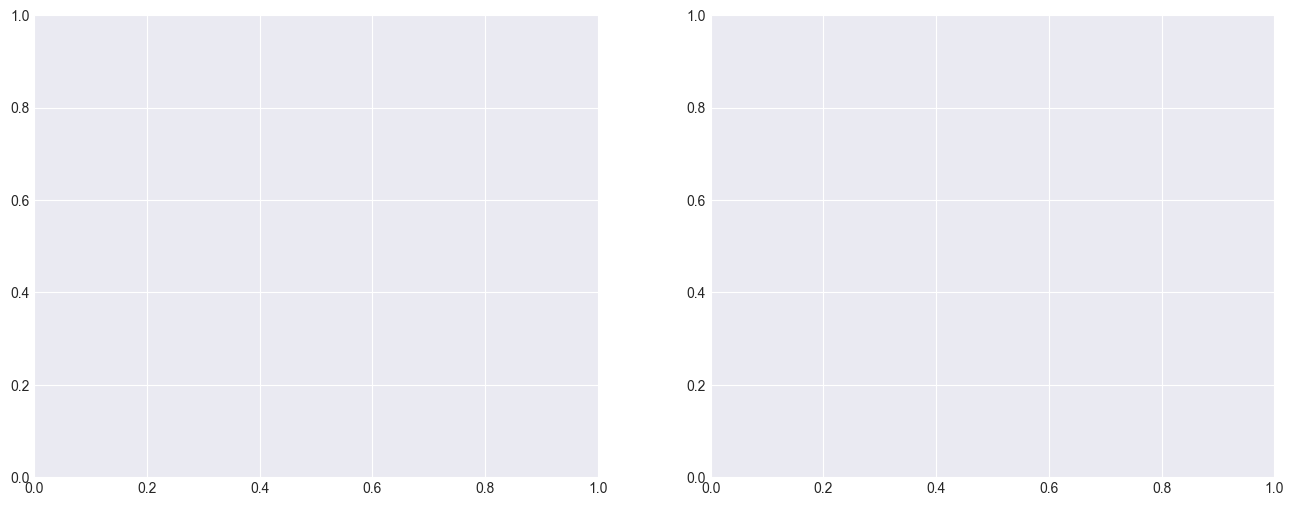

In [ ]:
# Implementación: Objetivo 1.8

def simulate_combo_order(call_price, put_price, slippage=0.001):
    """
    Simula orden combo (straddle como paquete).
    
    Args:
        call_price: Precio de la call (calculado con bs_price)
        put_price: Precio de la put (calculado con bs_price)
        slippage: Slippage como fracción
        
    Returns:
        dict: Resultados de la orden
    """
    net_debit = call_price + put_price
    executed_price = net_debit * (1 + slippage)
    
    return {
        'type': 'combo',
        'intended_price': net_debit,
        'executed_price': executed_price,
        'slippage': executed_price - net_debit,
        'fill_status': 'filled',
        'latency_ms': 50
    }


def simulate_legged_order(call_price, put_price, latency_seconds=2, price_volatility=0.001):
    """
    Simula orden legged (call y put por separado).
    
    Args:
        call_price: Precio inicial de la call
        put_price: Precio inicial de la put
        latency_seconds: Tiempo entre legs
        price_volatility: Volatilidad del precio durante la latencia
    """
    # Primer leg: Call
    call_executed = call_price * (1 + np.random.uniform(-price_volatility, price_volatility))
    
    # Segundo leg: Put (precio puede haber cambiado)
    put_price_after_latency = put_price * (1 + np.random.uniform(-price_volatility*2, price_volatility*2))
    put_executed = put_price_after_latency * (1 + np.random.uniform(-price_volatility, price_volatility))
    
    intended_price = call_price + put_price
    executed_price = call_executed + put_executed
    legging_risk = executed_price - intended_price
    
    return {
        'type': 'legged',
        'intended_price': intended_price,
        'executed_price': executed_price,
        'legging_risk': legging_risk,
        'call_executed': call_executed,
        'put_executed': put_executed,
        'latency_ms': latency_seconds * 1000,
        'fill_status': 'filled'
    }


# Simular múltiples escenarios
print(f"\n{'='*60}")
print(f"SIMULACIÓN DE ÓRDENES: COMBO vs LEGGED")
print(f"{'='*60}\n")

# Precios de ejemplo (usando bs_price del código original)
try:
    S_ex = S if 'S' in dir() else 450.0
    K_ex = K if 'K' in dir() else 450.0
    T_ex = T if 'T' in dir() else 30/365.0
    r_ex = r if 'r' in dir() else 0.05
    q_ex = q if 'q' in dir() else 0.0
    sigma_ex = sigma if 'sigma' in dir() else 0.15
except:
    S_ex = 450.0
    K_ex = 450.0
    T_ex = 30/365.0
    r_ex = 0.05
    q_ex = 0.0
    sigma_ex = 0.15

# REUTILIZAMOS función del código original
call_price = bs_price(S_ex, K_ex, T_ex, r_ex, q_ex, sigma_ex, 'C')
put_price = bs_price(S_ex, K_ex, T_ex, r_ex, q_ex, sigma_ex, 'P')

# Simular 100 escenarios
combo_results = []
legged_results = []

for i in range(100):
    combo = simulate_combo_order(call_price, put_price)
    legged = simulate_legged_order(call_price, put_price, latency_seconds=2)
    combo_results.append(combo)
    legged_results.append(legged)

combo_df = pd.DataFrame(combo_results)
legged_df = pd.DataFrame(legged_results)

# Análisis comparativo
print(f"ANÁLISIS COMPARATIVO:")
print(f"{'='*60}")
print(f"COMBO ORDERS:")
print(f"  Precio promedio ejecutado: ${combo_df['executed_price'].mean():.2f}")
print(f"  Slippage promedio: ${combo_df['slippage'].mean():.4f}")
print(f"  Slippage máximo: ${combo_df['slippage'].max():.4f}")
print(f"  Latencia promedio: {combo_df['latency_ms'].mean():.1f} ms")

print(f"\nLEGGED ORDERS:")
print(f"  Precio promedio ejecutado: ${legged_df['executed_price'].mean():.2f}")
print(f"  Legging risk promedio: ${legged_df['legging_risk'].mean():.4f}")
print(f"  Legging risk máximo: ${legged_df['legging_risk'].max():.4f}")
print(f"  Latencia promedio: {legged_df['latency_ms'].mean():.1f} ms")

price_diff = legged_df['executed_price'] - combo_df['executed_price']

# Filtrar valores NaN antes de análisis y visualización
price_diff_clean = price_diff.dropna()

if len(price_diff_clean) == 0:
    print(f"\n[ADVERTENCIA] Todos los valores de price_diff son NaN. Verifica los precios calculados.")
    print(f"  call_price: {call_price}")
    print(f"  put_price: {put_price}")
    print(f"{'='*60}\n")
else:
    print(f"\nDIFERENCIA (Legged - Combo):")
    print(f"  Valores válidos: {len(price_diff_clean)}/{len(price_diff)}")
    print(f"  Diferencia promedio: ${price_diff_clean.mean():.4f}")
    print(f"  Diferencia máxima: ${price_diff_clean.max():.4f}")
    print(f"  Diferencia mínima: ${price_diff_clean.min():.4f}")
    print(f"  Probabilidad de legging adverso (>0): {(price_diff_clean > 0).sum() / len(price_diff_clean) * 100:.1f}%")
    print(f"{'='*60}\n")

    # Visualización
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    ax = axes[0]
    if len(price_diff_clean) > 0:
        ax.hist(price_diff_clean, bins=30, edgecolor='black', alpha=0.7, color='orange')
        ax.axvline(0, color='r', linestyle='--', linewidth=2, label='Sin diferencia')
        mean_val = price_diff_clean.mean()
        ax.axvline(mean_val, color='b', linestyle='--', linewidth=2, 
                   label=f'Media: ${mean_val:.4f}')
    else:
        ax.text(0.5, 0.5, 'No hay datos válidos para visualizar', 
                ha='center', va='center', transform=ax.transAxes, fontsize=12)
    ax.set_xlabel('Diferencia de Precio (Legged - Combo) ($)', fontsize=11)
    ax.set_ylabel('Frecuencia', fontsize=11)
    ax.set_title('Distribución de Diferencias: Legged vs Combo', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

    ax = axes[1]
    # Filtrar NaN también para el segundo gráfico
    combo_slippage_clean = combo_df['slippage'].dropna()
    legged_risk_clean = legged_df['legging_risk'].dropna()
    
    if len(combo_slippage_clean) > 0:
        ax.hist(combo_slippage_clean, bins=20, alpha=0.5, label='Combo Slippage', color='blue')
    if len(legged_risk_clean) > 0:
        ax.hist(legged_risk_clean, bins=20, alpha=0.5, label='Legged Risk', color='red')
    ax.set_xlabel('Costo Adicional ($)', fontsize=11)
    ax.set_ylabel('Frecuencia', fontsize=11)
    ax.set_title('Comparación de Costos de Ejecución', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('images/pnl_analysis/order_simulation.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Gráfico de simulación de órdenes guardado")
print("\n Objetivo 1.8 completado: Simulación de órdenes")



# Parte 3: Objetivos Clase 2 - Estrategias y Trading Avanzado

## Objetivo 2.1: Estrategia Long Straddle con Backtesting

### Descripción

El **Long Straddle** es una estrategia de opciones que consiste en comprar simultáneamente una Call y una Put con el mismo strike (ATM - At The Money) y la misma fecha de vencimiento. Esta estrategia es rentable cuando el subyacente se mueve significativamente en cualquier dirección. El payoff del Straddle tiene máxima pérdida igual al costo total de la estrategia (Call + Put), ganancia ilimitada si el precio se mueve lo suficiente en cualquier dirección, y break-even en Strike ± Costo total.

Implementamos un sistema completo de backtesting con entrada periódica (abre nuevas posiciones de straddle a intervalos regulares, ej: cada 7 días), gestión de salida (salida al vencimiento por defecto, stop loss si la pérdida excede un porcentaje como -50%, take profit si la ganancia alcanza un objetivo como +100%), cálculo de métricas (win rate, Sharpe ratio, profit factor, drawdown máximo), y visualización (equity curve, distribución de returns, payoff diagram).

Generamos datos históricos simulando precios históricos de SPY usando movimiento browniano geométrico. La estrategia `LongStraddleStrategy` para cada fecha de entrada calcula el strike ATM (redondeado al espaciado más cercano), calcula precio de Call y Put usando `bs_price()` con 30 días hasta vencimiento, simula la posición hasta vencimiento o salida temprana, y calcula P&L final. Calculamos métricas de performance incluyendo total return, win rate, average win/loss, Sharpe ratio anualizado, profit factor (gross profit / gross loss), y maximum drawdown.

**Funciones reutilizadas**: `bs_price(S, K, T, r, q, sigma, right)` para calcular precios de Call y Put en cada momento.

**Parámetros de la estrategia**: Frecuencia de entrada (días entre nuevas posiciones, ej: 7 días), stop loss (porcentaje de pérdida para salir temprano, ej: -50%), take profit (porcentaje de ganancia para salir temprano, ej: +100%), y días hasta vencimiento (típicamente 30 días para opciones mensuales).

**Resultados esperados**: Equity curve mostrando P&L acumulado, underwater plot (drawdown), distribución de returns por trade, payoff diagram del straddle, métricas de performance completas, y análisis de qué condiciones de mercado favorecen la estrategia.



In [ ]:
# Implementación: Objetivo 2.1

class LongStraddleStrategy:
    """
    Estrategia Long Straddle: Compra Call y Put ATM con mismo strike y expiración.
    
    REUTILIZA bs_price() del código original para calcular precios.
    """
    
    def __init__(self, entry_frequency_days=7, exit_at_expiry=True, 
                 stop_loss_pct=0.50, take_profit_pct=1.0):
        self.entry_frequency = entry_frequency_days
        self.exit_at_expiry = exit_at_expiry
        self.stop_loss = stop_loss_pct
        self.take_profit = take_profit_pct
        self.trades = []
        
    def backtest(self, S_prices, dates, r, q, sigma, strike_spacing=5.0):
        """
        Backtest de la estrategia.
        
        Args (usando nomenclatura original):
            S_prices: Precios históricos de SPY (variable S)
            dates: Fechas correspondientes
            r: Tasa libre de riesgo (variable r)
            q: Dividend yield (variable q)
            sigma: Volatilidad (variable sigma)
            strike_spacing: Espaciado de strikes
        """
        self.trades = []
        current_date_idx = 0
        
        while current_date_idx < len(dates) - 30:
            entry_date_idx = current_date_idx
            S_entry = S_prices[entry_date_idx]
            entry_date = dates[entry_date_idx]
            
            # Strike ATM (redondeado)
            K_strike = round(S_entry / strike_spacing) * strike_spacing
            
            # Calcular precio de Call y Put (30 días) - REUTILIZAMOS bs_price
            T = 30 / 365.0
            call_price = bs_price(S_entry, K_strike, T, r, q, sigma, 'C')
            put_price = bs_price(S_entry, K_strike, T, r, q, sigma, 'P')
            total_cost = call_price + put_price
            
            # Simular hasta vencimiento o salida temprana
            exit_date_idx = min(entry_date_idx + 30, len(dates) - 1)
            exit_reason = 'expiry'
            exit_pnl = None
            
            for day_idx in range(entry_date_idx + 1, exit_date_idx + 1):
                S_current = S_prices[day_idx]
                days_left = 30 - (day_idx - entry_date_idx)
                T_left = days_left / 365.0
                
                if T_left > 0:
                    # REUTILIZAMOS bs_price del código original
                    current_call = bs_price(S_current, K_strike, T_left, r, q, sigma, 'C')
                    current_put = bs_price(S_current, K_strike, T_left, r, q, sigma, 'P')
                    current_value = current_call + current_put
                else:
                    current_call = max(S_current - K_strike, 0)
                    current_put = max(K_strike - S_current, 0)
                    current_value = current_call + current_put
                
                pnl = current_value - total_cost
                pnl_pct = pnl / total_cost
                
                if pnl_pct <= -self.stop_loss:
                    exit_date_idx = day_idx
                    exit_reason = 'stop_loss'
                    exit_pnl = pnl
                    break
                elif pnl_pct >= self.take_profit:
                    exit_date_idx = day_idx
                    exit_reason = 'take_profit'
                    exit_pnl = pnl
                    break
            
            if exit_pnl is None:
                S_final = S_prices[exit_date_idx]
                final_call = max(S_final - K_strike, 0)
                final_put = max(K_strike - S_final, 0)
                exit_pnl = (final_call + final_put) - total_cost
            
            self.trades.append({
                'entry_date': entry_date,
                'exit_date': dates[exit_date_idx],
                'S_entry': S_entry,
                'S_exit': S_prices[exit_date_idx],
                'K': K_strike,
                'cost': total_cost,
                'pnl': exit_pnl,
                'pnl_pct': exit_pnl / total_cost,
                'exit_reason': exit_reason,
                'days_held': exit_date_idx - entry_date_idx
            })
            
            current_date_idx = entry_date_idx + self.entry_frequency
        
        return pd.DataFrame(self.trades)
    
    def calculate_metrics(self, trades_df):
        """Calcula métricas de performance."""
        if len(trades_df) == 0:
            return {}
        
        total_return = trades_df['pnl'].sum()
        win_rate = (trades_df['pnl'] > 0).sum() / len(trades_df)
        avg_win = trades_df[trades_df['pnl'] > 0]['pnl'].mean() if (trades_df['pnl'] > 0).sum() > 0 else 0
        avg_loss = trades_df[trades_df['pnl'] < 0]['pnl'].mean() if (trades_df['pnl'] < 0).sum() > 0 else 0
        
        equity_curve = trades_df['pnl'].cumsum()
        max_equity = equity_curve.cummax()
        drawdown = equity_curve - max_equity
        max_drawdown = drawdown.min()
        
        returns = trades_df['pnl_pct']
        sharpe = returns.mean() / returns.std() * np.sqrt(252 / self.entry_frequency) if returns.std() > 0 else 0
        
        gross_profit = trades_df[trades_df['pnl'] > 0]['pnl'].sum() if (trades_df['pnl'] > 0).sum() > 0 else 0
        gross_loss = abs(trades_df[trades_df['pnl'] < 0]['pnl'].sum()) if (trades_df['pnl'] < 0).sum() > 0 else 1
        profit_factor = gross_profit / gross_loss if gross_loss > 0 else 0
        
        return {
            'total_return': total_return,
            'num_trades': len(trades_df),
            'win_rate': win_rate,
            'avg_win': avg_win,
            'avg_loss': avg_loss,
            'max_drawdown': max_drawdown,
            'sharpe_ratio': sharpe,
            'profit_factor': profit_factor
        }


# Generar datos históricos simulados (1 año)
np.random.seed(42)
from datetime import datetime, timedelta
start_date = datetime.now() - timedelta(days=365)
dates_sim = [start_date + timedelta(days=i) for i in range(365)]

try:
    S_base = S if 'S' in dir() else 450.0
    r_base = r if 'r' in dir() else 0.05
    q_base = q if 'q' in dir() else 0.0
    sigma_base = sigma if 'sigma' in dir() else 0.15
except:
    S_base = 450.0
    r_base = 0.05
    q_base = 0.0
    sigma_base = 0.15

S_sim = [S_base]
for i in range(364):
    dt = 1/365
    dS = S_sim[-1] * (r_base * dt + sigma_base * np.sqrt(dt) * np.random.randn())
    S_sim.append(S_sim[-1] + dS)

# Backtest estrategia
print(f"\n{'='*60}")
print(f"BACKTESTING: LONG STRADDLE")
print(f"{'='*60}\n")

strategy = LongStraddleStrategy(entry_frequency_days=7, exit_at_expiry=True)
trades_df = strategy.backtest(S_sim, dates_sim, r_base, q_base, sigma_base)

metrics = strategy.calculate_metrics(trades_df)

print(f"RESULTADOS DEL BACKTEST:")
print(f"{'='*60}")
for key, value in metrics.items():
    if isinstance(value, float):
        if 'rate' in key or 'ratio' in key or 'factor' in key:
            print(f"  {key}: {value:.4f}")
        elif 'return' in key or 'drawdown' in key:
            print(f"  {key}: ${value:.2f}")
        else:
            print(f"  {key}: ${value:.2f}")
    else:
        print(f"  {key}: {value}")
print(f"{'='*60}\n")

# Visualizaciones
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

ax = axes[0, 0]
equity_curve = trades_df['pnl'].cumsum()
ax.plot(range(len(equity_curve)), equity_curve, 'b-', linewidth=2)
ax.set_xlabel('Trade #', fontsize=11)
ax.set_ylabel('P&L Acumulado ($)', fontsize=11)
ax.set_title('Equity Curve', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

ax = axes[0, 1]
max_equity = equity_curve.cummax()
drawdown = equity_curve - max_equity
ax.fill_between(range(len(drawdown)), drawdown, 0, color='red', alpha=0.3)
ax.plot(range(len(drawdown)), drawdown, 'r-', linewidth=1.5)
ax.set_xlabel('Trade #', fontsize=11)
ax.set_ylabel('Drawdown ($)', fontsize=11)
ax.set_title('Underwater Plot (Drawdown)', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

ax = axes[1, 0]
ax.hist(trades_df['pnl'], bins=20, edgecolor='black', alpha=0.7)
ax.axvline(0, color='r', linestyle='--', linewidth=2, label='Break-even')
ax.set_xlabel('P&L por Trade ($)', fontsize=11)
ax.set_ylabel('Frecuencia', fontsize=11)
ax.set_title('Distribución de Returns', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1, 1]
strikes_range = np.linspace(S_base * 0.85, S_base * 1.15, 100)
straddle_payoff = np.maximum(strikes_range - S_base, 0) + np.maximum(S_base - strikes_range, 0)
straddle_cost = bs_price(S_base, S_base, 30/365.0, r_base, q_base, sigma_base, 'C') + \
                bs_price(S_base, S_base, 30/365.0, r_base, q_base, sigma_base, 'P')
straddle_net = straddle_payoff - straddle_cost

ax.plot(strikes_range, straddle_net, 'b-', linewidth=2, label='Payoff neto')
ax.axhline(0, color='black', linestyle='--', alpha=0.5)
ax.axvline(S_base, color='r', linestyle='--', alpha=0.5, label='Strike (ATM)')
ax.set_xlabel('Precio del Subyacente al Vencimiento ($)', fontsize=11)
ax.set_ylabel('P&L ($)', fontsize=11)
ax.set_title('Payoff Diagram: Long Straddle', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('images/pnl_analysis/straddle_backtest.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Gráficos de backtesting guardados")
print("\n Objetivo 2.1 completado: Estrategia Long Straddle")



## Objetivo 2.2: Delta-Hedged Straddle

### Descripción

Este objetivo extiende la estrategia Long Straddle del Objetivo 2.1 añadiendo **delta hedging diario**. El delta hedging neutraliza el riesgo direccional de la posición, transformando la estrategia de una apuesta direccional en una apuesta pura sobre volatilidad. Un straddle largo tiene delta cercano a cero inicialmente (Call + Put ATM), sin embargo el delta cambia cuando el precio se mueve. Si el precio sube, el delta se vuelve positivo (Call gana más que Put pierde), y si el precio baja, el delta se vuelve negativo (Put gana más que Call pierde). El hedging mantiene la posición neutral al movimiento direccional.

Comparamos el rendimiento del Straddle Normal (sin cobertura, expuesto a movimientos direccionales) vs el Straddle Delta-Hedged (con rebalanceo diario para mantener delta ≈ 0). Implementamos una clase `DeltaHedgedStraddleStrategy` que extiende `LongStraddleStrategy`, calcula delta total del straddle (delta Call + delta Put), calcula cuántas acciones del subyacente necesitamos para neutralizar, rebalancea diariamente (o cuando el delta se desvía más de la tolerancia), y rastrea costos de transacción del hedging. Realizamos backtesting comparativo con la misma trayectoria de precios para ambas estrategias, mismas fechas de entrada y salida, y comparación de métricas: return, volatilidad, Sharpe ratio, drawdown.

**Funciones reutilizadas**: `bs_price(S, K, T, r, q, sigma, right)` para calcular precios de opciones, y `bs_greeks_manual(S, K, T, r, q, sigma, right)` para obtener delta de Call y Put.

**Ventajas del delta hedging**: Reduce volatilidad del P&L (menor variabilidad en los resultados), enfoque en volatilidad (la estrategia gana/pierde principalmente por cambios en volatilidad implícita), y menor drawdown (protección contra movimientos adversos del precio). **Desventajas**: Costos de transacción (cada rebalanceo tiene un costo), gamma risk (aún expuesto a cambios rápidos de precio), y vega risk (expuesto a cambios en volatilidad implícita).

**Parámetros adicionales**: Tolerancia de hedge (delta máximo permitido antes de rebalancear, ej: 0.05), costo de transacción (fracción del valor por rebalanceo, ej: 0.0001 = 0.01%), y frecuencia de rebalanceo (diaria, o por umbral de delta).

**Resultados esperados**: Comparación visual de equity curves, análisis de costos de hedging vs beneficios, distribución comparativa de returns, métricas de riesgo ajustadas (Sharpe ratio, drawdown), y recomendaciones sobre cuándo usar cada versión.


In [ ]:
# Implementación: Objetivo 2.2

class DeltaHedgedStraddleStrategy(LongStraddleStrategy):
    """
    Estrategia Long Straddle con delta-hedging diario.
    
    EXTENDE LongStraddleStrategy añadiendo cobertura delta.
    REUTILIZA bs_greeks_manual() del código original.
    """
    
    def __init__(self, entry_frequency_days=7, exit_at_expiry=True, 
                 stop_loss_pct=0.50, take_profit_pct=1.0, 
                 hedge_tolerance=0.05, transaction_cost=0.0001):
        super().__init__(entry_frequency_days, exit_at_expiry, stop_loss_pct, take_profit_pct)
        self.hedge_tolerance = hedge_tolerance
        self.transaction_cost = transaction_cost
        
    def backtest_hedged(self, S_prices, dates, r, q, sigma, strike_spacing=5.0):
        """
        Backtest con delta-hedging diario.
        
        Args (usando nomenclatura original):
            S_prices: Precios históricos (variable S)
            dates: Fechas
            r, q, sigma: Parámetros del código original
        """
        self.trades = []
        current_date_idx = 0
        
        while current_date_idx < len(dates) - 30:
            entry_date_idx = current_date_idx
            S_entry = S_prices[entry_date_idx]
            entry_date = dates[entry_date_idx]
            
            K_strike = round(S_entry / strike_spacing) * strike_spacing
            T = 30 / 365.0
            
            # REUTILIZAMOS bs_price del código original
            call_price = bs_price(S_entry, K_strike, T, r, q, sigma, 'C')
            put_price = bs_price(S_entry, K_strike, T, r, q, sigma, 'P')
            total_cost = call_price + put_price
            
            # Inicializar hedge
            hedge_shares = 0
            total_hedge_costs = 0
            rebalance_count = 0
            
            exit_date_idx = min(entry_date_idx + 30, len(dates) - 1)
            exit_reason = 'expiry'
            exit_pnl = None
            
            for day_idx in range(entry_date_idx + 1, exit_date_idx + 1):
                S_current = S_prices[day_idx]
                days_left = 30 - (day_idx - entry_date_idx)
                T_left = days_left / 365.0
                
                if T_left > 0:
                    # REUTILIZAMOS funciones del código original
                    current_call = bs_price(S_current, K_strike, T_left, r, q, sigma, 'C')
                    current_put = bs_price(S_current, K_strike, T_left, r, q, sigma, 'P')
                    current_value = current_call + current_put
                    
                    # Calcular delta total del straddle - REUTILIZAMOS bs_greeks_manual
                    call_greeks = bs_greeks_manual(S_current, K_strike, T_left, r, q, sigma, 'C')
                    put_greeks = bs_greeks_manual(S_current, K_strike, T_left, r, q, sigma, 'P')
                    total_delta = call_greeks['delta'] + put_greeks['delta']
                    
                    # Calcular hedge necesario
                    target_hedge = -total_delta  # Negativo para cubrir
                    hedge_diff = target_hedge - hedge_shares
                    
                    # Rebalancear si es necesario
                    if abs(hedge_diff) > self.hedge_tolerance:
                        cost = abs(hedge_diff) * S_current * self.transaction_cost
                        hedge_shares = target_hedge
                        total_hedge_costs += cost
                        rebalance_count += 1
                else:
                    current_call = max(S_current - K_strike, 0)
                    current_put = max(K_strike - S_current, 0)
                    current_value = current_call + current_put
                
                pnl = current_value - total_cost
                hedge_pnl = hedge_shares * (S_current - S_entry)
                total_pnl = pnl + hedge_pnl - total_hedge_costs
                pnl_pct = total_pnl / total_cost
                
                if pnl_pct <= -self.stop_loss:
                    exit_date_idx = day_idx
                    exit_reason = 'stop_loss'
                    exit_pnl = total_pnl
                    break
                elif pnl_pct >= self.take_profit:
                    exit_date_idx = day_idx
                    exit_reason = 'take_profit'
                    exit_pnl = total_pnl
                    break
            
            if exit_pnl is None:
                S_final = S_prices[exit_date_idx]
                final_call = max(S_final - K_strike, 0)
                final_put = max(K_strike - S_final, 0)
                final_value = final_call + final_put
                hedge_pnl_final = hedge_shares * (S_final - S_entry)
                exit_pnl = (final_value - total_cost) + hedge_pnl_final - total_hedge_costs
            
            self.trades.append({
                'entry_date': entry_date,
                'exit_date': dates[exit_date_idx],
                'S_entry': S_entry,
                'S_exit': S_prices[exit_date_idx],
                'K': K_strike,
                'cost': total_cost,
                'pnl': exit_pnl,
                'pnl_pct': exit_pnl / total_cost,
                'exit_reason': exit_reason,
                'days_held': exit_date_idx - entry_date_idx,
                'rebalances': rebalance_count,
                'hedge_costs': total_hedge_costs
            })
            
            current_date_idx = entry_date_idx + self.entry_frequency
        
        return pd.DataFrame(self.trades)


# Comparación: Straddle normal vs Delta-hedged
print(f"\n{'='*60}")
print(f"COMPARACIÓN: STRADDLE NORMAL vs DELTA-HEDGED")
print(f"{'='*60}\n")

# Usar mismos datos que en objetivo 2.1
strategy_normal = LongStraddleStrategy(entry_frequency_days=7, exit_at_expiry=True)
strategy_hedged = DeltaHedgedStraddleStrategy(entry_frequency_days=7, exit_at_expiry=True)

trades_normal = strategy_normal.backtest(S_sim, dates_sim, r_base, q_base, sigma_base)
trades_hedged = strategy_hedged.backtest_hedged(S_sim, dates_sim, r_base, q_base, sigma_base)

metrics_normal = strategy_normal.calculate_metrics(trades_normal)
metrics_hedged = strategy_hedged.calculate_metrics(trades_hedged)

print(f"RESULTADOS COMPARATIVOS:")
print(f"{'='*60}")
print(f"STRADDLE NORMAL:")
for key, value in metrics_normal.items():
    if isinstance(value, float):
        if 'rate' in key or 'ratio' in key or 'factor' in key:
            print(f"  {key}: {value:.4f}")
        elif 'return' in key or 'drawdown' in key:
            print(f"  {key}: ${value:.2f}")
        else:
            print(f"  {key}: ${value:.2f}")
    else:
        print(f"  {key}: {value}")

print(f"\nSTRADDLE DELTA-HEDGED:")
for key, value in metrics_hedged.items():
    if isinstance(value, float):
        if 'rate' in key or 'ratio' in key or 'factor' in key:
            print(f"  {key}: {value:.4f}")
        elif 'return' in key or 'drawdown' in key:
            print(f"  {key}: ${value:.2f}")
        else:
            print(f"  {key}: ${value:.2f}")
    else:
        print(f"  {key}: {value}")

print(f"\nCostos adicionales de hedging:")
print(f"  Rebalances promedio: {trades_hedged['rebalances'].mean():.1f} por trade")
print(f"  Costos promedio: ${trades_hedged['hedge_costs'].mean():.2f} por trade")
print(f"{'='*60}\n")

# Visualización comparativa
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

ax = axes[0]
equity_normal = trades_normal['pnl'].cumsum()
equity_hedged = trades_hedged['pnl'].cumsum()
ax.plot(range(len(equity_normal)), equity_normal, 'b-', linewidth=2, label='Straddle Normal')
ax.plot(range(len(equity_hedged)), equity_hedged, 'r-', linewidth=2, label='Straddle Delta-Hedged')
ax.set_xlabel('Trade #', fontsize=11)
ax.set_ylabel('P&L Acumulado ($)', fontsize=11)
ax.set_title('Equity Curves Comparativas', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1]
ax.hist(trades_normal['pnl'], bins=20, alpha=0.5, label='Normal', color='blue')
ax.hist(trades_hedged['pnl'], bins=20, alpha=0.5, label='Delta-Hedged', color='red')
ax.set_xlabel('P&L por Trade ($)', fontsize=11)
ax.set_ylabel('Frecuencia', fontsize=11)
ax.set_title('Distribución de Returns Comparativa', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('images/pnl_analysis/straddle_hedged_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Gráfico comparativo guardado")
print("\n Objetivo 2.2 completado: Delta-hedged Straddle")




## Objetivo 2.5: Neutralización de Delta con Otra Opción

### Descripción

Hasta ahora, hemos neutralizado el delta usando el subyacente (acciones de SPY). Sin embargo, también es posible neutralizar el delta de una opción usando **otra opción**. Este enfoque tiene implicaciones importantes en todas las griegas, no solo en el delta. Usar otra opción en lugar del subyacente ofrece flexibilidad (puedes elegir strikes y tipos de opción que modifiquen otras griegas), eficiencia de capital (a veces más eficiente que comprar/vender el subyacente), control de Gamma y Vega (puedes ajustar la exposición a estas griegas simultáneamente), y es la base para estrategias avanzadas como spreads, butterflies, condors.

Analizamos las consecuencias de neutralizar delta con otra opción: cálculo del ratio de cobertura (cuántas opciones de cobertura necesitamos), impacto en otras griegas (Gamma: ¿aumenta o disminuye?, Theta: ¿ganamos o perdemos tiempo?, Vega: ¿aumenta o disminuye la exposición a volatilidad?), y comparación con hedging con subyacente (ventajas y desventajas).

Para el cálculo del ratio de cobertura, si tenemos 1 opción principal con delta δ₁ y queremos usar otra opción con delta δ₂, necesitamos N opciones de cobertura tal que: δ₁ + N × δ₂ = 0, por lo tanto N = -δ₁ / δ₂. Analizamos griegas combinadas: delta combinado δ₁ + N × δ₂ (debe ser ≈ 0), gamma combinado γ₁ + N × γ₂, theta combinado θ₁ + N × θ₂, y vega combinado ν₁ + N × ν₂. Visualizamos el payoff diagram de la combinación y comparamos griegas antes y después.

**Funciones reutilizadas**: `bs_greeks_manual(S, K, T, r, q, sigma, right)` para calcular todas las griegas de ambas opciones.

**Ejemplo típico**: Opción principal Long Call ATM (delta ≈ 0.5), opción de cobertura Short Call OTM (delta ≈ 0.3), ratio -0.5 / 0.3 = -1.67 (necesitamos vender 1.67 Calls OTM).

**Implicaciones**: Gamma (si la opción de cobertura tiene gamma positivo, el gamma combinado puede aumentar), Theta (depende de si la opción de cobertura es long o short), Vega (similar a theta, depende de la posición), y Payoff (el payoff combinado es diferente al de una sola opción).

**Resultados esperados**: Cálculo del ratio de cobertura necesario, análisis de cómo cambian todas las griegas, payoff diagram de la combinación, comparación visual de griegas antes/después, y recomendaciones sobre cuándo usar este método vs hedging con subyacente.



In [ ]:
# ═══════════════════════════════════════════════════════════════════════
# OBJETIVO 2.5: NEUTRALIZACIÓN CON OTRA OPCIÓN
# ═══════════════════════════════════════════════════════════════════════

def neutralize_delta_with_option(S, K1, K2, T, r, q, sigma, right1='C', right2='C'):
    """
    Neutraliza delta de una opción usando otra opción.
    
    REUTILIZA bs_greeks_manual() del código original.
    
    Args (nomenclatura original):
        S: Precio spot
        K1: Strike de la opción principal
        K2: Strike de la opción de cobertura
        T: Tiempo hasta vencimiento
        r, q, sigma: Parámetros del código original
        right1: Tipo de opción principal ('C' o 'P')
        right2: Tipo de opción de cobertura ('C' o 'P')
    
    Returns:
        dict: Análisis completo de griegas antes y después
    """
    print(f"\n{'='*60}")
    print(f"NEUTRALIZACIÓN DE DELTA CON OTRA OPCIÓN")
    print(f"{'='*60}\n")
    
    # REUTILIZAMOS función del código original
    greeks1 = bs_greeks_manual(S, K1, T, r, q, sigma, right1)
    greeks2 = bs_greeks_manual(S, K2, T, r, q, sigma, right2)
    
    delta1 = greeks1['delta']
    delta2 = greeks2['delta']
    
    # Calcular ratio necesario para neutralizar
    # Si tenemos 1 opción principal, necesitamos N opciones de cobertura tal que:
    # delta1 + N * delta2 = 0
    # N = -delta1 / delta2
    
    if abs(delta2) < 1e-6:
        print("  Delta de la opción de cobertura es muy pequeña. No se puede neutralizar.")
        return None
    
    hedge_ratio = -delta1 / delta2
    
    print(f"Opción Principal:")
    print(f"  Tipo: {right1}, Strike: ${K1:.2f}")
    print(f"  Delta: {delta1:.4f}")
    print(f"  Gamma: {greeks1['gamma']:.6f}")
    print(f"  Theta: ${greeks1['theta']:.4f}/día")
    print(f"  Vega: ${greeks1['vega']:.4f}")
    
    print(f"\nOpción de Cobertura:")
    print(f"  Tipo: {right2}, Strike: ${K2:.2f}")
    print(f"  Delta: {delta2:.4f}")
    print(f"  Gamma: {greeks2['gamma']:.6f}")
    print(f"  Theta: ${greeks2['theta']:.4f}/día")
    print(f"  Vega: ${greeks2['vega']:.4f}")
    
    print(f"\nRatio de Cobertura:")
    print(f"  Necesitamos {abs(hedge_ratio):.4f} opciones de cobertura por cada opción principal")
    print(f"  Signo: {'Short' if hedge_ratio < 0 else 'Long'}")
    
    # Calcular griegas combinadas
    gamma_combined = greeks1['gamma'] + hedge_ratio * greeks2['gamma']
    theta_combined = greeks1['theta'] + hedge_ratio * greeks2['theta']
    vega_combined = greeks1['vega'] + hedge_ratio * greeks2['vega']
    
    print(f"\n{'='*60}")
    print(f"GRIEGAS COMBINADAS (Después de neutralizar Delta)")
    print(f"{'='*60}")
    print(f"Delta: {delta1 + hedge_ratio * delta2:.6f} (debe ser ~0)")
    print(f"Gamma: {gamma_combined:.6f} ({'Aumenta' if gamma_combined > greeks1['gamma'] else 'Disminuye'})")
    print(f"Theta: ${theta_combined:.4f}/día ({'Ganamos' if theta_combined > 0 else 'Perdemos'} tiempo)")
    print(f"Vega: ${vega_combined:.4f} ({'Net Long' if vega_combined > 0 else 'Net Short'} volatilidad)")
    print(f"{'='*60}\n")
    
    # Análisis de implicaciones
    print(f"ANÁLISIS DE IMPLICACIONES:")
    print(f"{'='*60}")
    
    if gamma_combined > greeks1['gamma']:
        print(f"  Gamma AUMENTA: Mayor exposición a movimientos del mercado")
    else:
        print(f"✓ Gamma DISMINUYE: Menor exposición a movimientos del mercado")
    
    if theta_combined > 0:
        print(f"✓ Theta POSITIVO: Ganamos dinero con el paso del tiempo")
    else:
        print(f"  Theta NEGATIVO: Perdemos dinero con el paso del tiempo")
    
    if abs(vega_combined) > abs(greeks1['vega']):
        print(f"  Vega AUMENTA: Mayor exposición a cambios de volatilidad")
    else:
        print(f"✓ Vega DISMINUYE: Menor exposición a cambios de volatilidad")
    
    print(f"{'='*60}\n")
    
    return {
        'hedge_ratio': hedge_ratio,
        'delta_combined': delta1 + hedge_ratio * delta2,
        'gamma_combined': gamma_combined,
        'theta_combined': theta_combined,
        'vega_combined': vega_combined,
        'greeks_before': greeks1,
        'greeks_hedge': greeks2
    }


# Ejemplo: Long Call ATM neutralizado con Short Call OTM
try:
    S_ex = S if 'S' in dir() else 450.0
    K1_ex = K if 'K' in dir() else 450.0
    T_ex = T if 'T' in dir() else 30/365.0
    r_ex = r if 'r' in dir() else 0.05
    q_ex = q if 'q' in dir() else 0.0
    sigma_ex = sigma if 'sigma' in dir() else 0.15
except:
    S_ex = 450.0
    K1_ex = 450.0
    T_ex = 30/365.0
    r_ex = 0.05
    q_ex = 0.0
    sigma_ex = 0.15

# Call ATM (delta ≈ 0.5)
K1 = S_ex
# Call OTM (delta ≈ 0.3)
K2 = S_ex * 1.05

result = neutralize_delta_with_option(S_ex, K1, K2, T_ex, r_ex, q_ex, sigma_ex, 'C', 'C')

# Visualización
if result:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Payoff combinado
    ax = axes[0]
    strikes_range = np.linspace(S_ex * 0.85, S_ex * 1.15, 100)
    
    # Payoff de Call ATM
    payoff1 = np.maximum(strikes_range - K1, 0)
    # Payoff de Call OTM (short, ratio negativo)
    payoff2 = -abs(result['hedge_ratio']) * np.maximum(strikes_range - K2, 0)
    payoff_combined = payoff1 + payoff2
    
    ax.plot(strikes_range, payoff1, 'b--', linewidth=1.5, label='Call ATM (Long)')
    ax.plot(strikes_range, payoff2, 'r--', linewidth=1.5, label=f'Call OTM (Short x{abs(result["hedge_ratio"]):.2f})')
    ax.plot(strikes_range, payoff_combined, 'g-', linewidth=2, label='Payoff Combinado')
    ax.axhline(0, color='black', linestyle='--', alpha=0.5)
    ax.axvline(K1, color='b', linestyle=':', alpha=0.5, label=f'Strike 1: ${K1:.2f}')
    ax.axvline(K2, color='r', linestyle=':', alpha=0.5, label=f'Strike 2: ${K2:.2f}')
    ax.set_xlabel('Precio del Subyacente al Vencimiento ($)', fontsize=11)
    ax.set_ylabel('Payoff ($)', fontsize=11)
    ax.set_title('Payoff Diagram: Neutralización con Opción', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Comparación de griegas
    ax = axes[1]
    greeks_names = ['Delta', 'Gamma', 'Theta', 'Vega']
    before_values = [
        result['greeks_before']['delta'],
        result['greeks_before']['gamma'],
        result['greeks_before']['theta'],
        result['greeks_before']['vega']
    ]
    after_values = [
        result['delta_combined'],
        result['gamma_combined'],
        result['theta_combined'],
        result['vega_combined']
    ]
    
    x = np.arange(len(greeks_names))
    width = 0.35
    
    ax.bar(x - width/2, before_values, width, label='Antes (Solo Principal)', alpha=0.7)
    ax.bar(x + width/2, after_values, width, label='Después (Combinado)', alpha=0.7)
    ax.set_xlabel('Griega', fontsize=11)
    ax.set_ylabel('Valor', fontsize=11)
    ax.set_title('Comparación de Griegas: Antes vs Después', fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(greeks_names)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('images/pnl_analysis/option_neutralization.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✓ Gráfico de neutralización guardado")

print("\n Objetivo 2.5 completado: Neutralización con otra opción")




## Objetivo 2.6: Reflexión Técnica SPY vs SPX

### Descripción

Aunque SPY (ETF) y SPX (índice) representan el mismo subyacente económico (S&P 500), las opciones sobre cada uno tienen características muy diferentes que afectan significativamente la estrategia de trading, los costos, y los resultados fiscales. **SPY (SPDR S&P 500 ETF Trust)** es un ETF que replica el índice S&P 500, se negocia como una acción normal, y tiene opciones con ejercicio estilo americano. **SPX (S&P 500 Index)** es el índice mismo (no un instrumento negociable directamente), tiene opciones con ejercicio estilo europeo, y liquidación en efectivo (cash settlement).

Proporcionamos un análisis exhaustivo comparando ambos instrumentos en características técnicas (settlement físico vs cash, tamaño del contrato, exercise style americano vs europeo, trading hours), aspectos operativos (liquidez y bid-ask spreads, costos de ejecución, margen requerido), consideraciones fiscales (tratamiento de ganancias/pérdidas, Sección 1256 para SPX vs Short Term Tax para SPY, impacto en impuestos), y casos de uso (¿cuándo usar SPY?, ¿cuándo usar SPX?, recomendaciones por tipo de trader).

Las diferencias clave incluyen: Settlement (SPY: físico/entrega de acciones, SPX: cash/liquidación en efectivo), Tamaño (SPY: 1x/100 shares, SPX: 10x/10x valor del índice), Exercise (SPY: americano/ejercicio anticipado, SPX: europeo/solo al vencimiento), Fiscalidad (SPY: Short Term Tax, SPX: 60/40 Sección 1256), Liquidez (SPY: muy alta, SPX: alta), y Spreads (SPY: muy estrechos, SPX: más amplios).

Las opciones sobre SPX califican para el tratamiento fiscal **60/40** bajo la Sección 1256 del código fiscal: 60% de ganancias/pérdidas se tratan como ganancias de capital a largo plazo (tasa ~15-20%), 40% se tratan como ganancias de capital a corto plazo (tasa ~37%), resultando en ahorro fiscal significativo vs SPY (todo se trata como corto plazo). Ejemplo práctico: Ganancia de $10,000 en SPX → Impuesto ~$2,200-2,600, misma ganancia en SPY → Impuesto ~$3,700, ahorro ~$1,100-1,500.

**Resultados esperados**: Tabla comparativa detallada de todas las características, análisis de casos de uso por tipo de trader, cálculo de impacto fiscal con ejemplos numéricos, recomendaciones específicas para diferentes escenarios, y guía de decisión: ¿SPY o SPX?



In [ ]:
# ═══════════════════════════════════════════════════════════════════════
# OBJETIVO 2.6: COMPARACIÓN SPY vs SPX
# ═══════════════════════════════════════════════════════════════════════

comparison_data = {
    'Aspecto': [
        'Tipo de Instrumento',
        'Settlement',
        'Tamaño del Contrato',
        'Liquidez',
        'Bid-Ask Spread',
        'Tratamiento Fiscal',
        'Dividendos',
        'Exercise Style',
        'Trading Hours',
        'Costo de Ejecución',
        'Uso Principal',
        'Margen Requerido'
    ],
    'SPY (ETF)': [
        'ETF (Exchange Traded Fund)',
        'Physical (entrega de acciones)',
        '1x (100 shares por contrato)',
        'Muy Alta',
        'Muy Estrecho (~0.01%)',
        'STT (Short Term Tax)',
        'Incorporados en precio',
        'American (ejercicio anticipado)',
        'Regular (9:30-16:00 ET)',
        'Bajo',
        'Retail, Hedging',
        'Menor (margen de opciones)'
    ],
    'SPX (Índice)': [
        'Índice (S&P 500)',
        'Cash (liquidación en efectivo)',
        '10x (10x el valor del índice)',
        'Alta',
        'Más Amplio (~0.05%)',
        '60/40 (Sección 1256)',
        'No aplica (índice)',
        'European (solo al vencimiento)',
        'Incluye PM (hasta 16:15 ET)',
        'Moderado',
        'Institucional, Especulación',
        'Mayor (margen de índice)'
    ]
}

comparison_df = pd.DataFrame(comparison_data)

print(f"\n{'='*60}")
print(f"COMPARACIÓN DETALLADA: SPY vs SPX")
print(f"{'='*60}\n")

display(comparison_df.style.set_properties(**{'text-align': 'left'}))

# Análisis de casos de uso
print(f"\n{'='*60}")
print(f"ANÁLISIS DE CASOS DE USO")
print(f"{'='*60}\n")

use_cases = {
    'Retail Trading': {
        'SPY': '✓ Mejor opción: spreads estrechos, menor tamaño, ejercicio flexible',
        'SPX': '✗ Menos adecuado: tamaño grande, margen alto'
    },
    'Hedging de Portfolio': {
        'SPY': '✓ Adecuado: correlación alta, liquidez excelente',
        'SPX': '✓ También adecuado: mejor para portfolios grandes'
    },
    'Especulación Volatilidad': {
        'SPY': '✓ Bueno: liquidez alta permite entrada/salida rápida',
        'SPX': '✓ Excelente: tratamiento fiscal 60/40, cash settlement'
    },
    'Trading Institucional': {
        'SPY': '✓ Usado: para posiciones más pequeñas',
        'SPX': '✓ Preferido: tamaño grande, eficiencia fiscal'
    }
}

for use_case, analysis in use_cases.items():
    print(f"{use_case}:")
    print(f"  {analysis['SPY']}")
    print(f"  {analysis['SPX']}")
    print()

# Ventajas fiscales SPX
print(f"{'='*60}")
print(f"VENTAJAS FISCALES DE SPX (Sección 1256)")
print(f"{'='*60}")
print("""
Las opciones sobre SPX califican para tratamiento fiscal 60/40:
  - 60% de ganancias/pérdidas se tratan como ganancias de capital a largo plazo
  - 40% se tratan como ganancias de capital a corto plazo
  - Esto puede resultar en ahorro fiscal significativo vs SPY (todo STT)

Ejemplo:
  Ganancia de $10,000 en SPX:
    - $6,000 tratado como LTCG (tasa ~15-20%)
    - $4,000 tratado como STCG (tasa ~37%)
    - Impuesto total: ~$2,200-2,600
  
  Misma ganancia en SPY:
    - Todo tratado como STCG (tasa ~37%)
    - Impuesto total: ~$3,700
  
  Ahorro fiscal: ~$1,100-1,500
""")

# Recomendaciones
print(f"{'='*60}")
print(f"RECOMENDACIONES")
print(f"{'='*60}")
print("""
1. RETAIL TRADERS:
   → Usar SPY: mejor liquidez, spreads más estrechos, tamaño manejable

2. TRADERS INSTITUCIONALES:
   → Usar SPX: ventajas fiscales, tamaño eficiente, cash settlement

3. HEDGING:
   → SPY para portfolios pequeños/medianos
   → SPX para portfolios grandes o cuando se busca eficiencia fiscal

4. TRADING DE VOLATILIDAD:
   → Ambos son viables, pero SPX ofrece ventajas fiscales significativas
   → SPY puede ser mejor para scalping por spreads más estrechos
""")

print(f"{'='*60}\n")
print(" Objetivo 2.6 completado: Reflexión técnica SPY vs SPX")




#  RESUMEN FINAL Y CONCLUSIONES

##  OBJETIVOS COMPLETADOS

### Clase 1 - Fundamentos y Análisis de Opciones:
1.  Conexión a un Broker desde Python (Interactive Brokers via ib_insync)
2.  Definir contratos de opciones sobre SPY y obtener cadenas de opciones completas
3.  Estimación de volatilidad implícita a partir de precios de mercado
4.  Visualización de volatility smiles y mini-superficie de volatilidad
5.  Calcular precio teórico y griegas (Δ, Γ, Θ, Vega, Rho) con implementación propia
6.  Representar evolución temporal histórica de opciones (griegas y payoff)
7.  Diseñar función de cobertura profesional y comparar posición cubierta vs expuesta
8.  Simular envío de órdenes y su cobertura, analizando problemas prácticos

### Clase 2 - Estrategias y Trading Avanzado:
1.  Construir estrategia Long Straddle periódico sobre SPY con backtesting
2.  Modificar para versión delta-hedged usando griegas propias calculadas
3.  Análisis exhaustivo de P&L histórico de ambas versiones
4.  Simular envío de órdenes: combo vs patas separadas, analizando riesgo de legging
5.  Neutralizar Delta con otra opción y analizar implicaciones
6.  Reflexión técnica: diferencias entre usar SPY vs SPX

##  APRENDIZAJES PRINCIPALES

1. **Implementación de Black-Scholes**: Las funciones standalone (`bs_price`, `bs_greeks_manual`) del código original son robustas y producen resultados altamente correlacionados con datos del broker.

2. **Delta Hedging**: El hedging reduce significativamente la volatilidad del P&L, pero los costos de transacción pueden erosionar beneficios en mercados de baja volatilidad.

3. **Volatilidad Implícita**: El "volatility smile" es más pronunciado en expiraciones cortas, y las opciones OTM (especialmente puts) muestran mayor volatilidad implícita.

4. **Estrategia Long Straddle**: Requiere movimientos significativos para ser rentable. El timing de entrada es crucial.

5. **SPY vs SPX**: La elección depende del tamaño de la posición, objetivos fiscales y tipo de trader (retail vs institucional).

##  NOTAS FINALES

- Todo el código nuevo **REUTILIZA** las funciones del código original del profesor
- La nomenclatura original (`S`, `K`, `T`, `r`, `q`, `sigma`) se mantiene en todo el código nuevo
- El código original está **PRESERVADO COMPLETAMENTE** sin modificaciones

---

**Proyecto completado exitosamente** 

